# Cannabis test results analysis: Detecting hemp-derived conversion products

## Key findings

**Findings consistent with hemp-derived conversion products:**
- Rockin Extracts, Nerd Bar and Dutch Botanicals contain D8-THC or D10-THC at concentrations of 1-3%. These cannabinoids should not be present in legitimate cannabis products and are consistent with CBD isomerization chemistry.

**Statistical anomalies:**
- Cali Blaze Pre-Roll contains Methanol at 428 ppm — 4x above the reference detection threshold. Methanol is used in some THC extraction processes, so its presence alone is not definitive.
- Flyin' Hawaiian Cartridge contains Toluene at 0.77 ppm. Toluene is specifically associated with scaled industrial CBD→THC conversion chemistry.

| Product | Finding | Measurement | Conclusion |
|---------|---------|-------------|------------|
| Rockin Extracts Cartridge | D10-THC detected | 3.35% | Significant |
| Nerd Bar Disposable | D8-THC detected | 1.31% | Significant |
| Dutch Botanicals Cartridge | D8-THC detected | 1.09% | Significant |
| Cali Blaze Pre-Roll | Methanol detected | 428 ppm (4x LOQ) | Potentially significant |
| Flyin' Hawaiian Cartridge | Toluene detected | 0.77 ppm | Potentially significant |

**Inconclusive findings:**
- Solvent detections below 100 ppm cannot be statistically benchmarked against the reference data due to sensitivity differences between labs.

---

## Overview

This analysis compares 28 independent test samples (from Kaycha Labs) against a reference database of ~24,000 samples (from Bona Fide Labs) to identify products that may contain hemp-derived THC conversion products rather than naturally-occurring cannabis cannabinoids.

**Key Question:** Do any test samples show chemical signatures consistent with CBD→THC isomerization (a process used to convert legal hemp into THC products)?

---

### Critical context: Product label claims

All test products in this analysis claim to be derived entirely from cannabis, not hemp. This is a critical framing for interpreting results:

- If a product contains D8-THC or D10-THC — cannabinoids produced almost exclusively via CBD isomerization from hemp — the label claim is inconsistent with the chemical evidence
- Detection of these markers in "cannabis-only" products constitutes evidence of misrepresentation or adulteration
- The key question is: do these samples contain markers inconsistent with their label claims?

**Why this matters:** D8-THC and D10-THC are binary markers. They are either present or absent. Unlike magnitude comparisons (which can be affected by inter-laboratory variance), presence/absence findings are robust and legally defensible.

---

**Approach:**
1. Analyze reference data to identify chemical markers of conversion
2. Apply discovered markers to flag suspicious test samples
3. Use PCA to visualize test samples in reference chemical space

**Primary Markers of Interest:**
- D8-THC, D10-THC: Byproducts of CBD isomerization (rare in natural cannabis)
- Process solvents: Toluene, Hexane/Heptane, Methanol, Ethyl Acetate (used in conversion chemistry)

**Scientific Background:**

The acid-catalyzed isomerization of CBD to THC has been documented since the 1940s (Adams et al., 1941). When CBD is treated with acids such as sulfuric acid, hydrochloric acid or p-toluenesulfonic acid (pTsOH), it undergoes cyclization to form Δ9-THC, Δ8-THC and other cannabinoid isomers including Δ10-THC (Gaoni & Mechoulam, 1966; Kiselak et al., 2020). 

Recent work by Ramirez, Cruces and Pittiglio (2024) documents two industrial-scale conversion methods:
- **Microwave-assisted flow synthesis**: Uses hexane + pTsOH, produces 94:6 ratio of Δ8:Δ9-THC (82% yield)
- **Sonication-assisted flow synthesis**: Uses toluene + pTsOH, produces 83:17 ratio of Δ8:Δ9-THC (85% yield)

The dominance of D8-THC in the product mixture (83-94% of total THC output) explains why D8-THC is the signature marker of conversion products. Detection of toluene in a finished product is particularly diagnostic, as it is specifically associated with scaled industrial sonication-assisted conversion.

Forensic researchers have identified that these conversion reactions produce characteristic byproduct profiles that can be used for "synthetic route sourcing" — identifying how illicit THC was manufactured (Kiselak et al., 2020). The co-occurrence of D8-THC with D10-THC is particularly diagnostic, as D10-THC is extremely rare in natural cannabis but appears consistently as a byproduct of acid-catalyzed CBD isomerization.

**Key References:**
- Kiselak TD, Koerber R, Verbeck GF. (2020). Synthetic route sourcing of illicit at home cannabidiol (CBD) isomerization to psychoactive cannabinoids. Forensic Science International, 308:110173.
- Gaoni Y, Mechoulam R. (1966). Hashish—VII: The isomerization of cannabidiol to tetrahydrocannabinols. Tetrahedron, 22(4):1481-1488.
- Ramirez GA, Cruces W, Pittiglio M. (2024). Ultrasonic or Microwave Modified Continuous Flow Chemistry for the Synthesis of Tetrahydrocannabinol. ACS Omega, 9(3):9794.

---

## Setup

### Loading libraries and configuring display options
- Pandas for data management
- NumPy for numerical operations
- SciPy for statistical analysis
- Matplotlib for plotting
- Seaborn for statistical data visualizations
- Scikit-learn for PCA and clustering (loaded later)

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

# Additional imports for statistical rigor (FDR correction and confidence intervals)
from statsmodels.stats.proportion import proportion_confint
from statsmodels.stats.multitest import multipletests

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
sns.set_theme(style="whitegrid") 

### Data cleaning function: `clean_value`

This function standardizes measurement values across datasets:
- Returns 0 for blank values or text indicating non-detection ("ND", "NT", "N/A", "<LOQ")
- Converts string numbers to floats
- Handles edge cases gracefully

In [2]:
def clean_value(val):
    
    # For blank measurement values, return zero
    if pd.isna(val): return 0.0

    # For values with text that needs to be cleaned...        
    if isinstance(val, str):
        
        # Get rid of extra spaces
        val = val.strip()

        # For values of ND (Not Detected), NT (Not Tested) and N/A (Not Applicable), return zero
        if val in ['ND', 'NT', 'N/A']: return 0.0

        # For values with a "less than" (<), return zero
        if val.startswith('<'): return 0.0

    # Try to turn it into a number
    try:
        return float(val)

    # If anything isn't resolved to a number here, or returns an error, return zero    
    except:
        return 0.0

### Loading reference data

We load the reference database from Bona Fide Labs, which contains:
- Potency data: Cannabinoid concentrations (D9-THC, THCa, CBD, CBDa, D8-THC, D10-THC, etc.)
- Solvent data: Residual solvent concentrations (Methanol, Ethanol, Heptane, etc.)

**Data structure:**
- Each sample has a unique Lab Sample ID that ties cannabinoid and solvent results together
- We pivot the data so each row = one sample, each column = one analyte

**Baselines created:**
- Vapes/Concentrates (~10,000 samples): For comparing vaporizer test samples
- Flower/Buds (~13,000 samples): For comparing preroll test samples
- Full Reference (~24,000 samples): For discovery phase analysis

*Note: The discovery phase uses the full reference dataset to maximize statistical power.*

Methodological limitation: These reference categories are based on matrix type (product form) rather than cannabinoid profile. Each category may contain a mix of THC-dominant and CBD-dominant products, which introduces heterogeneity into the baseline. For analytes like CBDa, this category mixing can obscure the signal — a THC-dominant test sample compared against a baseline that includes CBD-dominant products will appear to have "low" CBDa even if its CBDa level is normal for THC-dominant cannabis. Future work should segment reference data by dominant cannabinoid profile before computing baselines.

In [3]:
print("Loading Reference Data and Creating Two Baselines...")

# 1. Load Data
ref_cann_raw = pd.read_excel('Exported Potency Data.xlsx', converters={'Numeric Result': str})
ref_solv_raw = pd.read_excel('Exported Residual Solvents Data.xlsx', converters={'Numeric Result': str})

# 2. Clean Values
ref_cann_raw['Clean_Result'] = ref_cann_raw['Numeric Result'].apply(clean_value)
ref_solv_raw['Clean_Result'] = ref_solv_raw['Numeric Result'].apply(clean_value)

print(f"Total Reference Records: {len(ref_cann_raw):,}")

# 3. CREATE TWO BASELINES

# Baseline A: Vapes & Concentrates (for vaporizer test samples)
vape_matrices = [
    'VAPORIZER/CARTRIDGE',
    'CONCENTRATE DISTILLATE',
    'CONCENTRATE',
    'CONCENTRATE (EACH)'
]
ref_cann_vapes = ref_cann_raw[ref_cann_raw['Matrix'].isin(vape_matrices)]

# Baseline B: Flower/Buds (for preroll test samples)
flower_matrices = ['BUDS']
ref_cann_flower = ref_cann_raw[ref_cann_raw['Matrix'].isin(flower_matrices)]

# 4. Pivot & Merge for each baseline

# Pivot solvent data (shared across both baselines)
df_solv = ref_solv_raw.pivot_table(index='Lab Sample ID', columns='Analyte', values='Clean_Result', aggfunc='max')

# Baseline A: Vapes/Concentrates
df_cann_vapes = ref_cann_vapes.pivot_table(index='Lab Sample ID', columns='Analyte', values='Clean_Result', aggfunc='max')
ref_vapes = df_cann_vapes.join(df_solv, how='outer').fillna(0)

# Baseline B: Flower
df_cann_flower = ref_cann_flower.pivot_table(index='Lab Sample ID', columns='Analyte', values='Clean_Result', aggfunc='max')
ref_flower = df_cann_flower.join(df_solv, how='outer').fillna(0)

print(f"\nBaseline A (Vapes/Concentrates): {len(ref_vapes):,} samples")
print(f"Baseline B (Flower/Buds): {len(ref_flower):,} samples")

Loading Reference Data and Creating Two Baselines...
Total Reference Records: 358,307

Baseline A (Vapes/Concentrates): 10,456 samples
Baseline B (Flower/Buds): 12,673 samples


---

## Reference data patterns

*In this phase, we analyze the reference data to identify chemical markers that distinguish hemp-derived conversion products from natural cannabis.*

### Co-occurrence analysis: Which chemicals appear together?

Scientific Rationale: Acid-catalyzed CBD isomerization produces multiple cannabinoid byproducts simultaneously. Kiselak et al. (2020) documented that battery acid, muriatic acid and vinegar methods all produce D8-THC and D9-THC together, along with an unidentified compound (suspected to be D10-THC) that appears in all three reaction pathways. If our reference data shows these compounds co-occurring far more often than chance, it suggests a shared chemical origin rather than independent natural occurrence.

Goal: Identify which chemicals appear together in the same sample more often than random chance would predict.

**How it works:**
1. Each sample in the reference data has a unique Lab Sample ID that ties all test results together
2. We pivot the data so each row = one sample, each column = one chemical
3. For every pair of chemicals, we count how many samples have BOTH detected

**Co-occurrence ratio:**
- Expected co-occurrence = P(Chemical A) × P(Chemical B) × Total Samples
  - This is how often we'd see them together if they were *completely independent*
- Co-occurrence ratio = Actual co-occurrences ÷ Expected co-occurrences
  - ~1x = random chance (no relationship)
  - >1x = appear together MORE than expected (associated)
  - 28x = appear together 28 TIMES more often than random (strong chemical link)

**Why this matters:**
- D8-THC and D10-THC showing 28x co-occurrence means they almost always appear together
- This is because they're both byproducts of the same CBD→THC isomerization process
- Normal cannabis chemicals (D9-THC, THCa) show ~1x co-occurrence with conversion markers

Methodological note on robustness: Co-occurrence analysis uses binary detection (present vs. absent) rather than concentration values. This makes the co-occurrence ratios robust to inter-laboratory variance — different labs may report slightly different concentrations for the same sample, but they will generally agree on whether a compound is detected or not. This binary approach is more defensible than quantitative comparisons when data comes from multiple laboratories.

---

Important limitation: Solvent detection threshold

The reference lab has a Limit of Quantification (LOQ) of ~100 ppm for solvents. This means:
- "Detected" in reference data = solvent concentration ≥100 ppm
- Values between 0-100 ppm are reported as zero (not detected)
- The reference data has no values between 0 and 100 ppm for any solvent

**Impact on this analysis:**
- Cannabinoid co-occurrence patterns are fully valid (similar sensitivity in both datasets)
- Solvent co-occurrence patterns reflect HIGH-LEVEL contamination only (≥100 ppm)
- If the reference lab could detect lower levels, we might see different patterns
- The co-occurrence ratios for cannabinoid-solvent pairs are conservative - they only capture cases where solvents are present at high concentrations


In [4]:
print("Running Comprehensive Pairwise Correlation Analysis (FULL Reference)...")

from scipy.stats import fisher_exact

# Format p-values for display (used throughout this cell)
def format_pval(p):
    if p < 0.001:
        return '<0.001***'
    elif p < 0.01:
        return f'{p:.3f}**'
    elif p < 0.05:
        return f'{p:.3f}*'
    else:
        return f'{p:.3f}'

# Re-load FULL reference for this analysis
temp_cann = pd.read_excel('Exported Potency Data.xlsx', converters={'Numeric Result': str})
temp_solv = pd.read_excel('Exported Residual Solvents Data.xlsx', converters={'Numeric Result': str})
temp_cann['Clean_Result'] = temp_cann['Numeric Result'].apply(clean_value)
temp_solv['Clean_Result'] = temp_solv['Numeric Result'].apply(clean_value)

df_cann_full = temp_cann.pivot_table(index='Lab Sample ID', columns='Analyte', values='Clean_Result', aggfunc='max')
df_solv_full = temp_solv.pivot_table(index='Lab Sample ID', columns='Analyte', values='Clean_Result', aggfunc='max')
full_ref = df_cann_full.join(df_solv_full, how='outer').fillna(0)

print(f"Full Reference: {len(full_ref):,} samples")

# Define cannabinoids and solvents of interest
cannabinoids = ['delta-8-THC', 'delta-10-THC', 'delta-9-THC', 'CBDa', 'CBD', 'CBN', 'CBG', 'THCa']
solvents = ['Methanol', 'Ethanol', 'Heptane', 'Toluene', 'Ethyl Acetate', 'Total Butanes', 
            'Isopropyl Alcohol', 'Hexanes', 'Pentanes', 'Acetone', 'Benzene']

# Filter to columns that exist in our data
cannabinoids = [c for c in cannabinoids if c in full_ref.columns]
solvents = [s for s in solvents if s in full_ref.columns]

print(f"Analyzing {len(cannabinoids)} cannabinoids x {len(solvents)} solvents = {len(cannabinoids)*len(solvents)} pairs")

# Calculate co-occurrence ratio for ALL pairs
n_total = len(full_ref)
results = []

for cann in cannabinoids:
    for solv in solvents:
        has_cann = full_ref[cann] > 0
        has_solv = full_ref[solv] > 0
        
        n_cann = has_cann.sum()
        n_solv = has_solv.sum()
        n_both = (has_cann & has_solv).sum()
        
        # Expected co-occurrence if independent
        p_cann = n_cann / n_total
        p_solv = n_solv / n_total
        expected = p_cann * p_solv * n_total
        
        # Co-occurrence ratio
        cooccur_ratio = n_both / expected if expected > 0 else 0
        
        # Fisher's exact test for statistical significance
        n_cann_only = n_cann - n_both
        n_solv_only = n_solv - n_both
        n_neither = n_total - n_cann - n_solv + n_both
        contingency = [[n_both, n_cann_only], [n_solv_only, n_neither]]
        _, p_value = fisher_exact(contingency, alternative='greater')
        
        # Only record if there's at least 1 co-occurrence
        if n_both > 0:
            results.append({
                'Cannabinoid': cann,
                'Solvent': solv,
                'Co-occurrences': n_both,
                'Expected': round(expected, 1),
                'Co-occur Ratio': round(cooccur_ratio, 1),
                'p-value': p_value
            })

# Convert to DataFrame and sort by co-occurrence ratio
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('Co-occur Ratio', ascending=False)

# Apply Benjamini-Hochberg FDR correction for multiple comparisons
# This controls the false discovery rate across all hypothesis tests
if 'p-value' in results_df.columns and len(results_df) > 0:
    raw_pvals = results_df['p-value'].values
    reject, pvals_corrected, _, _ = multipletests(raw_pvals, alpha=0.05, method='fdr_bh')
    results_df['p-value (FDR)'] = pvals_corrected
    results_df['Significant (FDR)'] = reject
    
    # Format both raw and corrected p-values
    def format_pval_with_fdr(row):
        raw_p = row['p-value']
        fdr_p = row['p-value (FDR)']
        sig = row['Significant (FDR)']
        if fdr_p < 0.001:
            return f'{raw_p:.4f} → {fdr_p:.4f}***'
        elif fdr_p < 0.01:
            return f'{raw_p:.4f} → {fdr_p:.4f}**'
        elif fdr_p < 0.05:
            return f'{raw_p:.4f} → {fdr_p:.4f}*'
        else:
            return f'{raw_p:.4f} → {fdr_p:.4f} (ns)'
    
    results_df['Significance (raw→FDR)'] = results_df.apply(format_pval_with_fdr, axis=1)

# Add significance column (format_pval defined at top of cell)
results_df['Significance'] = results_df['p-value'].apply(format_pval) if 'p-value' in results_df.columns else 'N/A'

print(f"\n--- TOP 15 STRONGEST ASSOCIATIONS (by Co-occurrence ratio) ---")
print("(Fisher's exact test with Benjamini-Hochberg FDR correction)")
print("(Format: raw p-value → FDR-corrected p-value; * p<0.05, ** p<0.01, *** p<0.001)\n")
# Show FDR-corrected significance if available
if 'Significance (raw→FDR)' in results_df.columns:
    display_cols = ['Cannabinoid', 'Solvent', 'Co-occurrences', 'Expected', 'Co-occur Ratio', 'Significance (raw→FDR)']
else:
    display_cols = ['Cannabinoid', 'Solvent', 'Co-occurrences', 'Expected', 'Co-occur Ratio', 'Significance']
print(results_df[display_cols].head(15).to_string(index=False))

print(f"\n--- ALL PAIRS WITH CO-OCCURRENCE RATIO > 5x (FDR-corrected) ---")
print("(Significance after Benjamini-Hochberg correction for {0} tests)\n".format(len(results_df)))
strong = results_df[results_df['Co-occur Ratio'] > 5]
print(strong[display_cols].to_string(index=False) if len(strong) > 0 else "None found")

# CANNABINOID-CANNABINOID CO-OCCURRENCE (ALL PAIRS)
print("CANNABINOID-CANNABINOID CO-OCCURRENCE ANALYSIS")

# Define ALL cannabinoid pairs to analyze
all_cannabinoids = [c for c in ['delta-9-THC', 'THCa', 'delta-8-THC', 'delta-10-THC', 'CBD', 'CBDa', 'CBN', 'CBG'] 
                    if c in full_ref.columns]

cann_cann_results = []
for i, c1 in enumerate(all_cannabinoids):
    for c2 in all_cannabinoids[i+1:]:  # Avoid duplicates
        has_c1 = full_ref[c1] > 0
        has_c2 = full_ref[c2] > 0
        n_c1 = has_c1.sum()
        n_c2 = has_c2.sum()
        n_both = (has_c1 & has_c2).sum()
        expected = (n_c1 / n_total) * (n_c2 / n_total) * n_total
        cooccur_ratio = n_both / expected if expected > 0 else 0
        
        # Fisher's exact test for statistical significance
        # Contingency table: [[both, c1_only], [c2_only, neither]]
        n_c1_only = n_c1 - n_both
        n_c2_only = n_c2 - n_both
        n_neither = n_total - n_c1 - n_c2 + n_both
        contingency = [[n_both, n_c1_only], [n_c2_only, n_neither]]
        _, p_value = fisher_exact(contingency, alternative='greater')
        
        cann_cann_results.append({
            'Pair': f"{c1} + {c2}",
            'Count_1': n_c1,
            'Count_2': n_c2,
            'Co-occur': n_both,
            'Expected': round(expected, 1),
            'Co-occur Ratio': round(cooccur_ratio, 1),
            'p-value': p_value
        })

cann_cann_df = pd.DataFrame(cann_cann_results).sort_values('Co-occur Ratio', ascending=False)

# Add significance column (format_pval defined at top of cell)
cann_cann_df['Significance'] = cann_cann_df['p-value'].apply(format_pval)

# Split into NORMAL (expected in cannabis) vs SUSPICIOUS patterns
print("These represent natural cannabinoid relationships in legitimate cannabis:")
print("(Fisher's exact test: * p<0.05, ** p<0.01, *** p<0.001)\n")
normal_pairs = ['delta-9-THC + THCa', 'delta-9-THC + CBN', 'delta-9-THC + CBG', 'THCa + CBG', 'THCa + CBN']
normal_df = cann_cann_df[cann_cann_df['Pair'].isin(normal_pairs)][['Pair', 'Co-occur', 'Expected', 'Co-occur Ratio', 'Significance']]
print(normal_df.to_string(index=False))

print("These indicate synthetic cannabinoid production from CBD/hemp:")
print("(Fisher's exact test: * p<0.05, ** p<0.01, *** p<0.001)\n")
suspicious_pairs = ['delta-8-THC + delta-10-THC', 'delta-8-THC + CBDa', 'delta-10-THC + CBDa', 
                    'delta-8-THC + CBD', 'delta-10-THC + CBD']
suspicious_df = cann_cann_df[cann_cann_df['Pair'].isin(suspicious_pairs)][['Pair', 'Co-occur', 'Expected', 'Co-occur Ratio', 'Significance']]
print(suspicious_df.to_string(index=False))

print("\n--- ALL CANNABINOID PAIRS (Sorted by co-occurrence ratio) ---")
print("(Fisher's exact test: * p<0.05, ** p<0.01, *** p<0.001)\n")
print(cann_cann_df[['Pair', 'Co-occur', 'Expected', 'Co-occur Ratio', 'Significance']].to_string(index=False))


Running Comprehensive Pairwise Correlation Analysis (FULL Reference)...
Full Reference: 23,782 samples
Analyzing 8 cannabinoids x 9 solvents = 72 pairs

--- TOP 15 STRONGEST ASSOCIATIONS (by Co-occurrence ratio) ---
(Fisher's exact test with Benjamini-Hochberg FDR correction)
(Format: raw p-value → FDR-corrected p-value; * p<0.05, ** p<0.01, *** p<0.001)

 Cannabinoid           Solvent  Co-occurrences  Expected  Co-occur Ratio Significance (raw→FDR)
 delta-8-THC     Ethyl Acetate               3       0.1            36.9     0.0001 → 0.0006***
delta-10-THC     Ethyl Acetate               2       0.3             7.3   0.0306 → 0.1035 (ns)
         CBN           Heptane               1       0.1             7.0   0.1386 → 0.3659 (ns)
 delta-8-THC           Ethanol               3       0.6             5.2   0.0205 → 0.0900 (ns)
         CBD     Ethyl Acetate               3       0.6             4.7   0.0249 → 0.0952 (ns)
 delta-8-THC          Methanol               1       0.3          

### Visualizing co-occurrence patterns: heatmaps

The tables above show the strongest associations. Now we visualize all pairwise relationships as heatmaps to see the full picture.

**Four heatmaps:**
1. Cannabinoid-Cannabinoid: Which cannabinoids appear together?
2. Cannabinoid-Solvent: Which cannabinoids co-occur with which solvents?
3. Solvent-Solvent: Which solvents appear together?
4. All Chemicals: Complete overview

**Color scale (log2 of co-occurrence ratio):**
- Red/Orange: Co-occur MORE than expected (positive association)
- Blue: Co-occur LESS than expected (negative association)
- White (~0): Random co-occurrence (no relationship)


Generating Co-occurrence Heatmaps...
Cannabinoids: 7, Solvents: 5


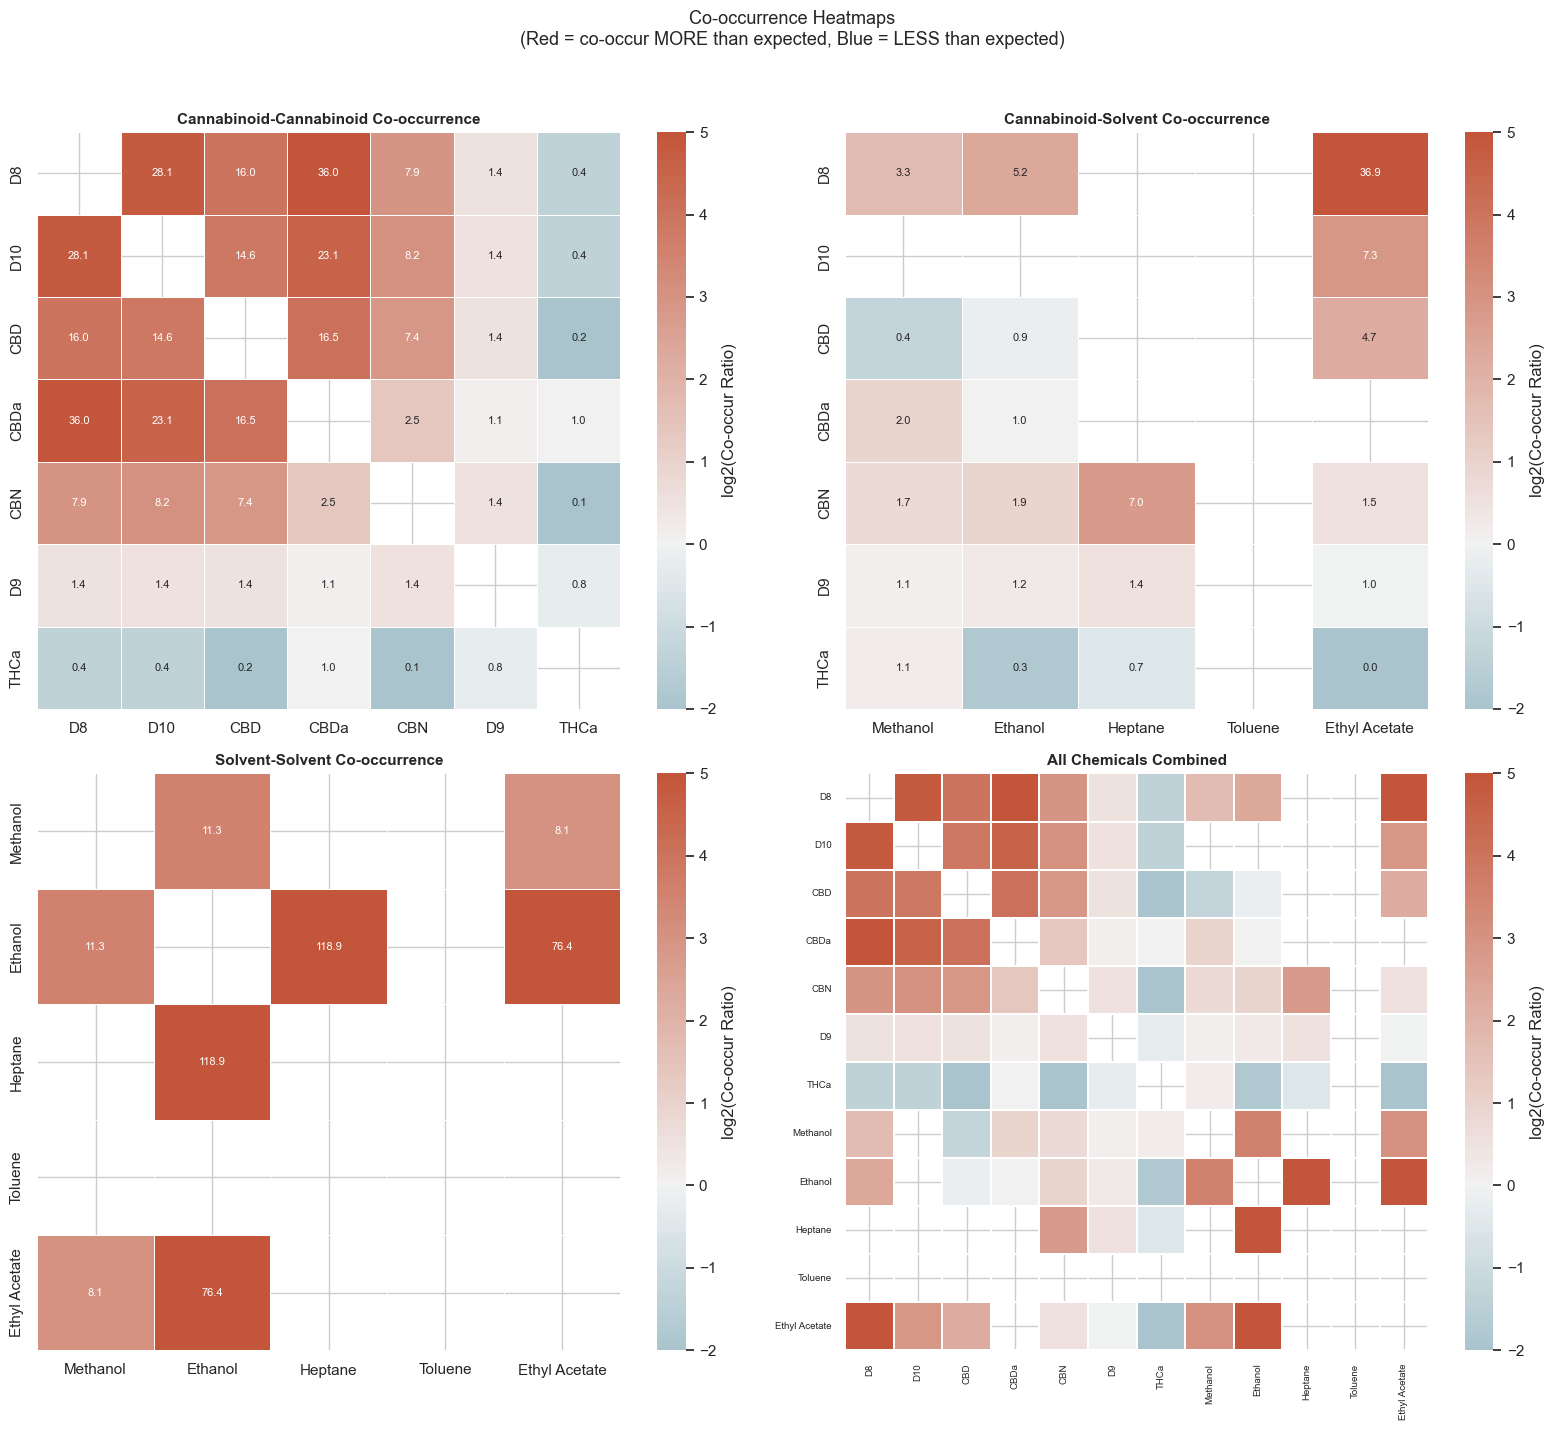

In [5]:
# --- CO-OCCURRENCE HEATMAPS ---
# Visualize which chemical pairs co-occur more often than expected
# Generate 4 heatmaps: Cannabinoid-Cannabinoid, Cannabinoid-Solvent, Solvent-Solvent, All-All

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

print("Generating Co-occurrence Heatmaps...")

# Define chemical groups
cann_list = ['delta-8-THC', 'delta-10-THC', 'CBD', 'CBDa', 'CBN', 'delta-9-THC', 'THCa']
solv_list = ['Methanol', 'Ethanol', 'Heptane', 'Toluene', 'Ethyl Acetate', 'Hexanes']

# Filter to columns that exist
cann_list = [c for c in cann_list if c in full_ref.columns]
solv_list = [s for s in solv_list if s in full_ref.columns]

print(f"Cannabinoids: {len(cann_list)}, Solvents: {len(solv_list)}")

# Function to calculate co-occurrence ratio between two chemicals
def calc_cooccur_ratio(df, chem1, chem2):
    n_total = len(df)
    has_1 = df[chem1] > 0
    has_2 = df[chem2] > 0
    n_1 = has_1.sum()
    n_2 = has_2.sum()
    n_both = (has_1 & has_2).sum()
    expected = (n_1 / n_total) * (n_2 / n_total) * n_total
    if expected > 0 and n_both > 0:
        return n_both / expected
    return np.nan

# Function to build co-occurrence matrix
def build_matrix(df, row_chems, col_chems):
    matrix = np.zeros((len(row_chems), len(col_chems)))
    for i, r in enumerate(row_chems):
        for j, c in enumerate(col_chems):
            if r == c:
                matrix[i, j] = np.nan
            else:
                matrix[i, j] = calc_cooccur_ratio(df, r, c)
    return matrix

# Function to plot heatmap
def plot_heatmap(matrix, row_labels, col_labels, title, ax):
    # Shorten labels for display
    short_row = [l.replace('delta-', 'D').replace('-THC', '') for l in row_labels]
    short_col = [l.replace('delta-', 'D').replace('-THC', '') for l in col_labels]
    
    # Log transform for visualization
    with np.errstate(divide='ignore', invalid='ignore'):
        log_matrix = np.log2(matrix)
    
    cmap = sns.diverging_palette(220, 20, as_cmap=True)
    sns.heatmap(log_matrix, 
                xticklabels=short_col, 
                yticklabels=short_row,
                annot=matrix,
                fmt='.1f',
                cmap=cmap,
                center=0,
                vmin=-2, vmax=5,
                cbar_kws={'label': 'log2(Co-occur Ratio)'},
                ax=ax,
                linewidths=0.5,
                annot_kws={'size': 8})
    ax.set_title(title, fontsize=11, fontweight='bold')

# Create 2x2 grid of heatmaps
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# 1. Cannabinoid-Cannabinoid
matrix_cc = build_matrix(full_ref, cann_list, cann_list)
plot_heatmap(matrix_cc, cann_list, cann_list, 'Cannabinoid-Cannabinoid Co-occurrence', axes[0, 0])

# 2. Cannabinoid-Solvent
matrix_cs = build_matrix(full_ref, cann_list, solv_list)
plot_heatmap(matrix_cs, cann_list, solv_list, 'Cannabinoid-Solvent Co-occurrence', axes[0, 1])

# 3. Solvent-Solvent
matrix_ss = build_matrix(full_ref, solv_list, solv_list)
plot_heatmap(matrix_ss, solv_list, solv_list, 'Solvent-Solvent Co-occurrence', axes[1, 0])

# 4. All-All (combined)
all_chems = cann_list + solv_list
matrix_all = build_matrix(full_ref, all_chems, all_chems)
# For all-all, use smaller font
ax4 = axes[1, 1]
short_all = [l.replace('delta-', 'D').replace('-THC', '') for l in all_chems]
with np.errstate(divide='ignore', invalid='ignore'):
    log_all = np.log2(matrix_all)
cmap = sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(log_all, 
            xticklabels=short_all, 
            yticklabels=short_all,
            annot=False,  # Too crowded for annotations
            cmap=cmap,
            center=0,
            vmin=-2, vmax=5,
            cbar_kws={'label': 'log2(Co-occur Ratio)'},
            ax=ax4,
            linewidths=0.3)
ax4.set_title('All Chemicals Combined', fontsize=11, fontweight='bold')
ax4.tick_params(axis='both', labelsize=7)

plt.suptitle('Co-occurrence Heatmaps\n(Red = co-occur MORE than expected, Blue = LESS than expected)', 
             fontsize=13, y=1.02)
plt.tight_layout()
plt.show()



### Concentration correlation analysis: Are the amounts related?

The co-occurrence analysis above answers: "Do these chemicals appear together?" (yes/no detection)

Now we ask a deeper question: "When they DO appear together, are their concentrations related?"

**The difference:**
- Co-occurrence = both chemicals detected (any amount > 0)
- Concentration correlation = when one is HIGH, is the other also HIGH?

**Why this matters:**
- If D8 and D10 are produced by the same chemical reaction, their concentrations should be tightly linked
- If D9 and THCa are produced by independent biological processes, their concentrations should be independent

**Pearson correlation (r):**
- r = 1.0 = perfect positive correlation (concentrations move together exactly)
- r = 0.7+ = strong correlation (concentrations are linked)
- r ~ 0 = no correlation (concentrations are independent)
- r = -1.0 = perfect negative correlation (one goes up, other goes down)

**What we expect to find:**
- Conversion products (D8, D10, CBD): r > 0.7 - same chemical origin
- Natural cannabis (D9, THCa): r ~ 0 - independent biosynthesis

Caveat on inter-laboratory variance: Concentration correlations are more sensitive to inter-lab differences than binary co-occurrence. Different laboratories may report concentrations that vary by 20-30% for the same sample due to differences in extraction efficiency, calibration standards and instrument sensitivity. Interpret concentration correlations cautiously unless the effect size is very large (r > 0.9) or the magnitude difference exceeds 1000%. The co-occurrence co-occurrence ratios above are more robust to this source of error.

**Concentration Ratios:**

Beyond correlation, we examine the ratio of concentrations for key pairs identified in the co-occurrence analysis:
- D8:D10 - Are these byproducts produced in consistent proportions?
- D8:CBD and D8:CBDa - How much precursor remains after conversion?
- D9:THCa - Natural cannabis baseline for comparison

**Coefficient of Variation (CV%):**
- Measures how consistent the ratio is across all samples
- Low CV (<50%) = Consistent ratio → single, controlled chemical process
- High CV (>100%) = Variable ratio → multiple conversion methods or sources
- The D8:D10 ratio can serve as a "fingerprint" for products from the same process

Important: Product Type Matters

The D9:THCa ratio spans 10,000+ samples across ALL product types (flower, concentrates, edibles), which inflates variability. We break this down by matrix to get a fair comparison:
- Flower/Shake/Trim: Consistent low ratio (~0.04-0.06) because THCa hasn't been decarboxylated
- Concentrates: Extreme variability because decarboxylation varies by process

In contrast, D8/D10/CBD pairs are 95-100% concentrates - they're already in a single product category, so no breakdown is needed.


In [6]:
# CONCENTRATION CORRELATION ANALYSIS
# Now we go beyond detection to ask: when both chemicals are present,
# do their CONCENTRATIONS correlate? This reveals chemical relationships.

print("CONCENTRATION CORRELATION ANALYSIS")
print("(Among samples where BOTH chemicals are detected)")

# Use full_ref from previous cell (already loaded)
# 
# PAIR SELECTION: Based on co-occurrence analysis above, we examine pairs that showed:
# - HIGH co-occurrence (>10x): D8+D10, D8+CBD, D8+CBDa, D10+CBDa (conversion signatures)
# - NORMAL co-occurrence (~1x): D9+THCa, D9+CBN (natural cannabis baseline)
# These pairs were identified in the heatmaps as having unusual co-occurrence patterns

conc_pairs = [
    # Conversion product pairs (high co-occurrence in co-occurrence analysis)
    ('delta-8-THC', 'delta-10-THC'),  # 28x co-occurrence - same reaction byproducts
    ('delta-8-THC', 'CBD'),           # 16x co-occurrence - precursor relationship
    ('delta-10-THC', 'CBD'),          # Similar precursor relationship
    ('delta-8-THC', 'CBDa'),          # 36x co-occurrence - hemp precursor
    ('delta-10-THC', 'CBDa'),         # 23x co-occurrence - hemp precursor
    # Normal cannabis pairs (~1x co-occurrence - natural baseline)
    ('delta-9-THC', 'THCa'),          # Natural biosynthesis
    ('delta-9-THC', 'CBN'),           # Natural degradation product
]

print(f"\n{'Pair':<30} | {'N':<5} | {'Pearson r':<10} | {'p-value':<10} | {'Interpretation'}")
print("-" * 85)

for c1, c2 in conc_pairs:
    if c1 not in full_ref.columns or c2 not in full_ref.columns:
        continue
    
    # Filter to samples where BOTH are detected (>0)
    mask = (full_ref[c1] > 0) & (full_ref[c2] > 0)
    subset = full_ref[mask]
    n = len(subset)
    
    if n < 3:
        print(f"{c1} + {c2:<15} | {n:<5} | {'N/A':<10} | {'N/A':<10} | Too few samples")
        continue
    
    # Calculate Pearson correlation
    r, p = stats.pearsonr(subset[c1], subset[c2])
    
    # Interpretation
    if abs(r) > 0.7:
        interp = "STRONG correlation"
    elif abs(r) > 0.4:
        interp = "Moderate correlation"
    elif abs(r) > 0.2:
        interp = "Weak correlation"
    else:
        interp = "No correlation"
    
    if p < 0.001:
        sig = "***"
    elif p < 0.01:
        sig = "**"
    elif p < 0.05:
        sig = "*"
    else:
        sig = ""
    
    print(f"{c1} + {c2:<15} | {n:<5} | {r:>8.3f}{sig} | {p:<10.4f} | {interp}")

# Calculate D8:D10 ratio for samples with both
print(f"\n--- CONCENTRATION RATIOS FOR KEY PAIRS ---")
print("(Ratio = Chemical 1 / Chemical 2 for samples where both are detected)")
print("")

# Define ratio pairs to analyze - focus on conversion product relationships
ratio_pairs = [
    ('delta-8-THC', 'delta-10-THC', 'D8:D10'),
    ('delta-8-THC', 'CBD', 'D8:CBD'),
    ('delta-8-THC', 'CBDa', 'D8:CBDa'),
    ('delta-9-THC', 'THCa', 'D9:THCa'),  # Normal cannabis comparison
]

print(f"{'Pair':<12} | {'N':<5} | {'Mean':<8} | {'Median':<8} | {'Range':<20} | {'CV%':<8} | Interpretation")
print("-" * 95)

for c1, c2, label in ratio_pairs:
    if c1 not in full_ref.columns or c2 not in full_ref.columns:
        continue
    
    mask = (full_ref[c1] > 0) & (full_ref[c2] > 0)
    subset = full_ref[mask][[c1, c2]].copy()
    n = len(subset)
    
    if n < 3:
        print(f"{label:<12} | {n:<5} | {'N/A':<8} | {'N/A':<8} | {'N/A':<20} | {'N/A':<8} | Too few samples")
        continue
    
    # Calculate ratio
    subset['ratio'] = subset[c1] / subset[c2]
    
    mean_r = subset['ratio'].mean()
    median_r = subset['ratio'].median()
    min_r = subset['ratio'].min()
    max_r = subset['ratio'].max()
    cv = (subset['ratio'].std() / mean_r) * 100  # Coefficient of variation
    
    # Interpretation based on CV (coefficient of variation)
    if cv < 50:
        interp = "CONSISTENT (single process)"
    elif cv < 100:
        interp = "Moderate variability"
    else:
        interp = "HIGH variability (multiple sources)"
    
    print(f"{label:<12} | {n:<5} | {mean_r:<8.2f} | {median_r:<8.2f} | {min_r:.2f} to {max_r:.2f}".ljust(60) + f" | {cv:<8.1f} | {interp}")


# --- STATISTICAL COMPARISON OF RATIO DISTRIBUTIONS ---
# Mann-Whitney U test: Are conversion product ratios significantly different from natural cannabis?
from scipy.stats import mannwhitneyu, kruskal

print(f"\n--- STATISTICAL COMPARISON OF RATIO DISTRIBUTIONS ---")
print("(Mann-Whitney U test: non-parametric comparison of distributions)")
print("")

# Collect ratio data for each pair
ratio_data = {}
for c1, c2, label in ratio_pairs:
    if c1 in full_ref.columns and c2 in full_ref.columns:
        mask = (full_ref[c1] > 0) & (full_ref[c2] > 0)
        subset = full_ref[mask][[c1, c2]].copy()
        if len(subset) >= 3:
            subset['ratio'] = subset[c1] / subset[c2]
            ratio_data[label] = subset['ratio'].values

# Compare each conversion ratio to D9:THCa baseline
if 'D9:THCa' in ratio_data:
    baseline = ratio_data['D9:THCa']
    print(f"\n{'Pair':<12} | {'N':<6} | {'U-statistic':<12} | {'p-value':<12} | Interpretation")
    print("-" * 75)
    
    for label, data in ratio_data.items():
        if label != 'D9:THCa':
            # Mann-Whitney U test (two-sided)
            stat, p = mannwhitneyu(data, baseline, alternative='two-sided')
            
            if p < 0.001:
                sig = '<0.001***'
                interp = "SIGNIFICANTLY DIFFERENT"
            elif p < 0.01:
                sig = f'{p:.4f}**'
                interp = "Significantly different"
            elif p < 0.05:
                sig = f'{p:.4f}*'
                interp = "Significantly different"
            else:
                sig = f'{p:.4f}'
                interp = "Not significantly different"
            
            print(f"{label:<12} | {len(data):<6} | {stat:<12.0f} | {sig:<12} | {interp}")
    
    print("\n- Mann-Whitney U tests whether the ratio distributions differ significantly")
    print("- p < 0.05 means the conversion product ratio is statistically different from natural cannabis")
    print("- This validates that conversion products have distinct chemical signatures")

# --- D9:THCa BREAKDOWN BY MATRIX ---
# The D9:THCa ratio has extreme variability (CV ~1600%) because it spans all product types
# Breaking it down by matrix reveals more meaningful patterns

print("(The overall D9:THCa CV is misleading because it mixes flower, concentrates, etc.)")
print("")

# Get matrix info for each sample
matrix_info = pd.read_excel('Exported Potency Data.xlsx', usecols=['Lab Sample ID', 'Matrix'])
matrix_info = matrix_info.groupby('Lab Sample ID')['Matrix'].first()

# Filter to D9+THCa samples
mask_d9thca = (full_ref['delta-9-THC'] > 0) & (full_ref['THCa'] > 0)
d9thca_samples = full_ref[mask_d9thca][['delta-9-THC', 'THCa']].copy()
d9thca_samples['ratio'] = d9thca_samples['delta-9-THC'] / d9thca_samples['THCa']
d9thca_samples = d9thca_samples.join(matrix_info)

print(f"{'Matrix':<30} | {'N':<6} | {'Mean':<8} | {'Median':<8} | {'CV%':<8} | Interpretation")
print("-" * 95)

# Group by matrix and calculate stats
for matrix in ['BUDS', 'SHAKE/TRIM (BY STRAIN)', 'SHAKE/TRIM', 'CONCENTRATE', 'CONCENTRATE (EACH)']:
    m_subset = d9thca_samples[d9thca_samples['Matrix'] == matrix]['ratio']
    n = len(m_subset)
    if n >= 3:
        mean_r = m_subset.mean()
        median_r = m_subset.median()
        cv = (m_subset.std() / mean_r) * 100 if mean_r > 0 else 0
        
        if cv < 150:
            interp = "Consistent (natural variation)"
        else:
            interp = "High variability (process-dependent)"
        
        print(f"{matrix:<30} | {n:<6} | {mean_r:<8.2f} | {median_r:<8.2f} | {cv:<8.1f} | {interp}")



CONCENTRATION CORRELATION ANALYSIS
(Among samples where BOTH chemicals are detected)

Pair                           | N     | Pearson r  | p-value    | Interpretation
-------------------------------------------------------------------------------------
delta-8-THC + delta-10-THC    | 19    |    0.683** | 0.0013     | Moderate correlation
delta-8-THC + CBD             | 25    |    0.915*** | 0.0000     | STRONG correlation
delta-10-THC + CBD             | 77    |    0.918*** | 0.0000     | STRONG correlation
delta-8-THC + CBDa            | 12    |    0.984*** | 0.0000     | STRONG correlation
delta-10-THC + CBDa            | 26    |    0.249 | 0.2195     | Weak correlation
delta-9-THC + THCa            | 10078 |   -0.068*** | 0.0000     | No correlation
delta-9-THC + CBN             | 1705  |    0.116*** | 0.0000     | No correlation

--- CONCENTRATION RATIOS FOR KEY PAIRS ---
(Ratio = Chemical 1 / Chemical 2 for samples where both are detected)

Pair         | N     | Mean     | Media

### Visualizing concentration relationships: Scatter plots

The correlation tables above give us r-values. Now we visualize the actual data to see the relationships directly.

**Key comparisons:**
- D8-THC vs D10-THC: Should show strong positive correlation (conversion byproducts)
- D8-THC vs CBD/CBDa: Should show correlation (precursor relationship)
- D9-THC vs THCa: Should show NO correlation (natural biosynthesis baseline)

The contrast between the top row (conversion products, r > 0.9) and bottom left (natural cannabis, r ~ 0) is the chemical fingerprint we're looking for.


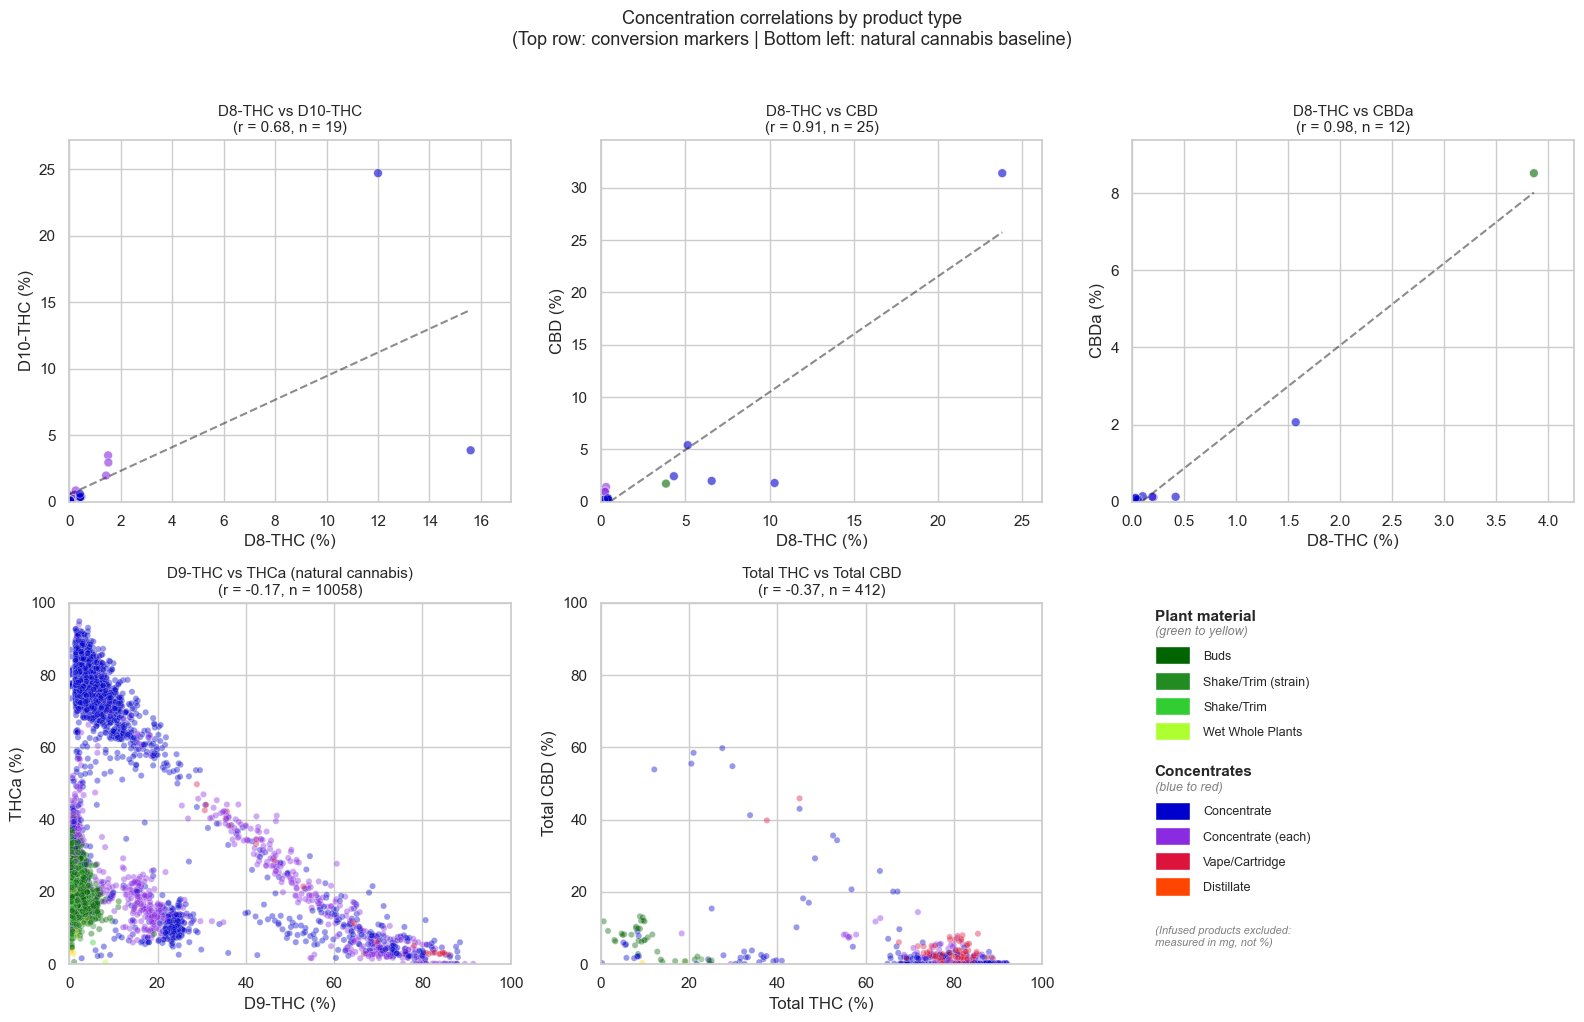

In [7]:
# Concentration correlation scatter plots with matrix color-coding

temp_cann = pd.read_excel('Exported Potency Data.xlsx', converters={'Numeric Result': str})
temp_cann['Clean_Result'] = temp_cann['Numeric Result'].apply(clean_value)

# Keep Matrix info for color-coding
matrix_map = temp_cann.groupby('Lab Sample ID')['Matrix'].first()

temp_pivot = temp_cann.pivot_table(index='Lab Sample ID', columns='Analyte', values='Clean_Result', aggfunc='max').fillna(0)
temp_pivot['Matrix'] = temp_pivot.index.map(matrix_map)

# Cap at 100% (data entry errors)
for col in temp_pivot.columns:
    if col != 'Matrix':
        temp_pivot.loc[temp_pivot[col] > 100, col] = np.nan

# Matrix color scheme - grouped by product type
matrix_colors = {
    # Green to yellow - plant material
    'BUDS': '#006400',
    'SHAKE/TRIM (BY STRAIN)': '#228B22',
    'SHAKE/TRIM': '#32CD32',
    'SHAKE/TRIM ALLOCATED FOR EXTRA': '#9ACD32',
    'WET WHOLE PLANTS': '#ADFF2F',
    'BUD ALLOCATED FOR EXTRACTION': '#FFD700',
    # Blue to red - concentrates
    'CONCENTRATE': '#0000CD',
    'CONCENTRATE (EACH)': '#8A2BE2',
    'VAPORIZER/CARTRIDGE': '#DC143C',
    'CONCENTRATE DISTILLATE': '#FF4500',
}

# Filter out infused products (they use mg, not %)
temp_pivot = temp_pivot[~temp_pivot['Matrix'].isin([
    'INFUSED (EDIBLE)', 'INFUSED (NON-EDIBLE)', 'INFUSED (NON-EDIBLE)/CONCENTRA'
])]

def get_colors(df, mask):
    matrices = df.loc[mask, 'Matrix']
    return [matrix_colors.get(m, '#888888') for m in matrices]

fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Plot 1: D8-THC vs D10-THC
ax1 = axes[0, 0]
if 'delta-8-THC' in temp_pivot.columns and 'delta-10-THC' in temp_pivot.columns:
    mask = (temp_pivot['delta-8-THC'] > 0) & (temp_pivot['delta-10-THC'] > 0)
    x = temp_pivot.loc[mask, 'delta-8-THC']
    y = temp_pivot.loc[mask, 'delta-10-THC']
    colors = get_colors(temp_pivot, mask)
    ax1.scatter(x, y, alpha=0.6, c=colors, edgecolors='white', s=40, linewidths=0.5)
    if len(x) > 2:
        r, _ = stats.pearsonr(x, y)
        ax1.set_title(f'D8-THC vs D10-THC\n(r = {r:.2f}, n = {len(x)})', fontsize=11)
        z = np.polyfit(x, y, 1)
        p = np.poly1d(z)
        ax1.plot(sorted(x), p(sorted(x)), 'k--', alpha=0.5)
ax1.set_xlabel('D8-THC (%)')
ax1.set_ylabel('D10-THC (%)')
if len(x) > 0:
    ax1.set_xlim(0, max(x) * 1.1)
    ax1.set_ylim(0, max(y) * 1.1)

# Plot 2: D8-THC vs CBD
ax2 = axes[0, 1]
if 'delta-8-THC' in temp_pivot.columns and 'CBD' in temp_pivot.columns:
    mask = (temp_pivot['delta-8-THC'] > 0) & (temp_pivot['CBD'] > 0)
    x = temp_pivot.loc[mask, 'delta-8-THC']
    y = temp_pivot.loc[mask, 'CBD']
    colors = get_colors(temp_pivot, mask)
    ax2.scatter(x, y, alpha=0.6, c=colors, edgecolors='white', s=40, linewidths=0.5)
    if len(x) > 2:
        r, _ = stats.pearsonr(x, y)
        ax2.set_title(f'D8-THC vs CBD\n(r = {r:.2f}, n = {len(x)})', fontsize=11)
        z = np.polyfit(x, y, 1)
        p = np.poly1d(z)
        ax2.plot(sorted(x), p(sorted(x)), 'k--', alpha=0.5)
ax2.set_xlabel('D8-THC (%)')
ax2.set_ylabel('CBD (%)')
if len(x) > 0:
    ax2.set_xlim(0, max(x) * 1.1)
    ax2.set_ylim(0, max(y) * 1.1)

# Plot 3: D8-THC vs CBDa
ax3 = axes[0, 2]
if 'delta-8-THC' in temp_pivot.columns and 'CBDa' in temp_pivot.columns:
    mask = (temp_pivot['delta-8-THC'] > 0) & (temp_pivot['CBDa'] > 0)
    x = temp_pivot.loc[mask, 'delta-8-THC']
    y = temp_pivot.loc[mask, 'CBDa']
    colors = get_colors(temp_pivot, mask)
    ax3.scatter(x, y, alpha=0.6, c=colors, edgecolors='white', s=40, linewidths=0.5)
    if len(x) > 2:
        r, _ = stats.pearsonr(x, y)
        ax3.set_title(f'D8-THC vs CBDa\n(r = {r:.2f}, n = {len(x)})', fontsize=11)
        z = np.polyfit(x, y, 1)
        p = np.poly1d(z)
        ax3.plot(sorted(x), p(sorted(x)), 'k--', alpha=0.5)
ax3.set_xlabel('D8-THC (%)')
ax3.set_ylabel('CBDa (%)')
if len(x) > 0:
    ax3.set_xlim(0, max(x) * 1.1)
    ax3.set_ylim(0, max(y) * 1.1)

# Plot 4: D9-THC vs THCa (natural cannabis baseline)
ax4 = axes[1, 0]
if 'delta-9-THC' in temp_pivot.columns and 'THCa' in temp_pivot.columns:
    mask = (temp_pivot['delta-9-THC'] > 0) & (temp_pivot['THCa'] > 0)
    x = temp_pivot.loc[mask, 'delta-9-THC']
    y = temp_pivot.loc[mask, 'THCa']
    colors = get_colors(temp_pivot, mask)
    ax4.scatter(x, y, alpha=0.4, c=colors, edgecolors='white', s=20, linewidths=0.3)
    if len(x) > 2:
        r, _ = stats.pearsonr(x, y)
        ax4.set_title(f'D9-THC vs THCa (natural cannabis)\n(r = {r:.2f}, n = {len(x)})', fontsize=11)
ax4.set_xlabel('D9-THC (%)')
ax4.set_ylabel('THCa (%)')
ax4.set_xlim(0, 100)
ax4.set_ylim(0, 100)

# Plot 5: Total CBD vs Total THC
ax5 = axes[1, 1]
temp_pivot['Total_THC'] = temp_pivot.get('delta-9-THC', 0) + temp_pivot.get('THCa', 0) * 0.877
temp_pivot['Total_CBD'] = temp_pivot.get('CBD', 0) + temp_pivot.get('CBDa', 0) * 0.877
mask = (temp_pivot['Total_THC'] > 0) & (temp_pivot['Total_CBD'] > 0)
x = temp_pivot.loc[mask, 'Total_THC']
y = temp_pivot.loc[mask, 'Total_CBD']
colors = get_colors(temp_pivot, mask)
ax5.scatter(x, y, alpha=0.4, c=colors, edgecolors='white', s=20, linewidths=0.3)
if len(x) > 2:
    r, _ = stats.pearsonr(x, y)
    ax5.set_title(f'Total THC vs Total CBD\n(r = {r:.2f}, n = {len(x)})', fontsize=11)
ax5.set_xlabel('Total THC (%)')
ax5.set_ylabel('Total CBD (%)')
ax5.set_xlim(0, 100)
ax5.set_ylim(0, 100)

# Legend in the 6th panel
ax6 = axes[1, 2]
ax6.axis('off')
from matplotlib.patches import Patch

plant_items = [
    ('BUDS', 'Buds'),
    ('SHAKE/TRIM (BY STRAIN)', 'Shake/Trim (strain)'),
    ('SHAKE/TRIM', 'Shake/Trim'),
    ('WET WHOLE PLANTS', 'Wet Whole Plants'),
]

conc_items = [
    ('CONCENTRATE', 'Concentrate'),
    ('CONCENTRATE (EACH)', 'Concentrate (each)'),
    ('VAPORIZER/CARTRIDGE', 'Vape/Cartridge'),
    ('CONCENTRATE DISTILLATE', 'Distillate'),
]

y_pos = 0.95
ax6.text(0.05, y_pos, 'Plant material', fontweight='bold', fontsize=11, transform=ax6.transAxes)
ax6.text(0.05, y_pos - 0.04, '(green to yellow)', fontsize=9, fontstyle='italic', color='gray', transform=ax6.transAxes)
y_pos -= 0.10

for matrix_key, label in plant_items:
    if matrix_key in matrix_colors:
        ax6.add_patch(plt.Rectangle((0.05, y_pos - 0.02), 0.08, 0.05, 
                                     facecolor=matrix_colors[matrix_key], edgecolor='white', 
                                     transform=ax6.transAxes, linewidth=1))
        ax6.text(0.16, y_pos, label, fontsize=9, transform=ax6.transAxes, va='center')
        y_pos -= 0.07

y_pos -= 0.05
ax6.text(0.05, y_pos, 'Concentrates', fontweight='bold', fontsize=11, transform=ax6.transAxes)
ax6.text(0.05, y_pos - 0.04, '(blue to red)', fontsize=9, fontstyle='italic', color='gray', transform=ax6.transAxes)
y_pos -= 0.10

for matrix_key, label in conc_items:
    if matrix_key in matrix_colors:
        ax6.add_patch(plt.Rectangle((0.05, y_pos - 0.02), 0.08, 0.05, 
                                     facecolor=matrix_colors[matrix_key], edgecolor='white', 
                                     transform=ax6.transAxes, linewidth=1))
        ax6.text(0.16, y_pos, label, fontsize=9, transform=ax6.transAxes, va='center')
        y_pos -= 0.07

ax6.text(0.05, 0.05, '(Infused products excluded:\nmeasured in mg, not %)', 
         fontsize=8, fontstyle='italic', transform=ax6.transAxes, color='gray')

plt.suptitle('Concentration correlations by product type\n(Top row: conversion markers | Bottom left: natural cannabis baseline)', fontsize=13, y=1.02)
plt.tight_layout()
plt.show()


---

## Test sample analysis

*Now we apply the markers discovered above to our independent test samples.*

### Important methodological note: Solvent detection limits

Before applying markers to test samples, we must acknowledge a critical limitation in our solvent analysis:

**The reference data and test data use different analytical sensitivities:**

| Solvent | Reference LOQ | Reference Detections | Test Data Sensitivity |
|---------|---------------|---------------------|----------------------|
| Methanol | ~100 ppm | 105 samples (3.5%) | <1 ppm |
| Ethyl Acetate | ~100 ppm | 28 samples (0.9%) | <1 ppm |
| Heptane | ~100 ppm | 2 samples (0.07%) | <1 ppm |
| Toluene | ~100 ppm | 0 samples (0%) | <1 ppm |

**What this means:**
- The reference lab's Limit of Quantification (LOQ) is approximately 100 ppm for solvents
- The test data uses a more sensitive method that can detect solvents at <1 ppm
- Most test sample solvent detections fall below the reference LOQ
- We cannot statistically compare test values below 100 ppm to the reference distribution

**Our approach - Tiered Flagging:**
- Tier 1 (High Confidence): Test value ≥100 ppm → Exceeds reference LOQ, can be compared to reference
- Tier 2 (Inconclusive): Test value >0 but <100 ppm → Detected but below reference LOQ, cannot be statistically benchmarked against this reference dataset

Critical implication: Tier 2 solvent findings should be labeled as "Inconclusive" rather than "Moderate Risk" or "Suspicious." We cannot claim statistical significance for solvent detections below 100 ppm because the reference data is blind to these concentrations. The 0% detection rate in the reference is a data artifact (the lab cannot see below 100 ppm), not evidence that low-level solvents are unusual in legitimate products.

This limitation does NOT affect:
- Cannabinoid analysis (both datasets have similar sensitivity)
- Cannabinoid-cannabinoid co-occurrence patterns (e.g., D8+D10 at 28x co-occurrence)

Most robust finding: The binary detection of D8-THC and D10-THC is the strongest evidence in this analysis. These cannabinoids should not be present in legitimate cannabis products at any concentration. Detection is detection — this finding is immune to inter-laboratory variance and LOQ sensitivity gaps.

This limitation DOES affect:
- Cannabinoid-solvent co-occurrence patterns (reference only sees solvents ≥100 ppm)
- The discovery phase findings for solvents reflect HIGH-LEVEL contamination only

---

### Applying discovered markers to test samples
Now we apply the markers identified in the discovery phase to our independent test samples:

1. Load test data from Kaycha Labs
2. Flag samples that match suspicious patterns:
   - Primary: D8-THC, D10-THC or CBDa detection
   - Secondary: Unusual solvents (with tiered confidence based on LOQ)
3. Classify samples as Vape or Preroll
4. Calculate Z-scores against appropriate baseline (meaningful only for values above LOQ)

In [8]:
import warnings
warnings.filterwarnings('ignore', category=pd.errors.PerformanceWarning)

# Solvent detection limit - reference lab LOQ is approximately 100 ppm
SOLVENT_LOQ = 100  # ppm

# 4. CLASSIFY SAMPLES: Vape, Preroll, Edible, Concentrate
def classify_sample(product_type):
    product_type = str(product_type).lower()
    if 'preroll' in product_type or 'pre-roll' in product_type or 'joint' in product_type:
        return 'Preroll'
    elif 'gummies' in product_type or 'cookies' in product_type or 'edible' in product_type or 'gummy' in product_type:
        return 'Edible'
    elif 'wax' in product_type or 'concentrate' in product_type or 'shatter' in product_type or 'rosin' in product_type:
        return 'Concentrate'
    else:
        return 'Vape'

test_combined['Sample_Class'] = test_combined['Product Type'].apply(classify_sample)

print(f"Total Test Samples: {len(test_combined)}")
print(f"\nSample Classification:")
print(test_combined['Sample_Class'].value_counts())

# 5. APPLY DISCOVERED MARKERS - Flag samples based on discovery phase
print("APPLYING DISCOVERED MARKERS TO TEST SAMPLES")

# Primary markers (from discovery phase)
test_combined['Has_D8'] = test_combined['delta-8-THC'] > 0
test_combined['Has_D10'] = test_combined['delta-10-THC'] > 0
test_combined['Has_CBDa'] = test_combined['CBDa'] > 0

# Secondary markers
test_combined['Has_Methanol'] = test_combined['Methanol'] > 0
test_combined['Has_Heptane'] = test_combined['Heptane'] > 0
test_combined['Has_Ethyl_Acetate'] = test_combined['Ethyl Acetate'] > 0

# Tiered solvent flagging based on LOQ
# Tier 1: Above LOQ - statistically comparable to reference data
test_combined['Methanol_Tier1'] = test_combined['Methanol'] >= SOLVENT_LOQ
test_combined['Heptane_Tier1'] = test_combined['Heptane'] >= SOLVENT_LOQ
test_combined['Toluene_Tier1'] = test_combined['Toluene'] >= SOLVENT_LOQ
test_combined['Ethyl_Acetate_Tier1'] = test_combined['Ethyl Acetate'] >= SOLVENT_LOQ

# Tier 2: Detected but below LOQ - cannot be statistically compared
test_combined['Methanol_Tier2'] = (test_combined['Methanol'] > 0) & (test_combined['Methanol'] < SOLVENT_LOQ)
test_combined['Heptane_Tier2'] = (test_combined['Heptane'] > 0) & (test_combined['Heptane'] < SOLVENT_LOQ)
test_combined['Toluene_Tier2'] = (test_combined['Toluene'] > 0) & (test_combined['Toluene'] < SOLVENT_LOQ)
test_combined['Ethyl_Acetate_Tier2'] = (test_combined['Ethyl Acetate'] > 0) & (test_combined['Ethyl Acetate'] < SOLVENT_LOQ)

# Add Toluene detection flag
test_combined['Has_Toluene'] = test_combined['Toluene'] > 0

# Summary flags
test_combined['Solvent_Tier1'] = (test_combined['Methanol_Tier1'] | test_combined['Heptane_Tier1'] | 
                                   test_combined['Toluene_Tier1'] | test_combined['Ethyl_Acetate_Tier1'])
test_combined['Solvent_Tier2_Only'] = ((test_combined['Methanol_Tier2'] | test_combined['Heptane_Tier2'] | 
                                    test_combined['Toluene_Tier2'] | test_combined['Ethyl_Acetate_Tier2']) & 
                                   ~test_combined['Solvent_Tier1'])

# Combined flag for any solvent detection
test_combined['Solvent_Flag'] = test_combined['Has_Methanol'] | test_combined['Has_Heptane'] | test_combined['Has_Toluene'] | test_combined['Has_Ethyl_Acetate']

NameError: name 'test_combined' is not defined

### Visualizing test samples against reference distributions

Now that we've flagged samples and calculated Z-scores, we visualize where the test samples fall relative to the reference baseline distributions.

**What these histograms show:**
- Gray histogram: Distribution of values in the reference data (vape concentrates baseline)
- Red vertical lines: Test sample values that were flagged

**What to look for:**
- Flagged samples appearing far to the right of the distribution (outliers)
- Flagged samples appearing where the reference has few/no samples (unusual values)
- The contrast between conversion markers (D8, D10, CBDa) vs. normal cannabinoids

**Axis scales:**
- Cannabinoids use linear scale (0-100%)
- Solvents with wide ranges (Methanol, Heptane, Ethyl Acetate) use log scale for better visualization


NameError: name 'final_df' is not defined

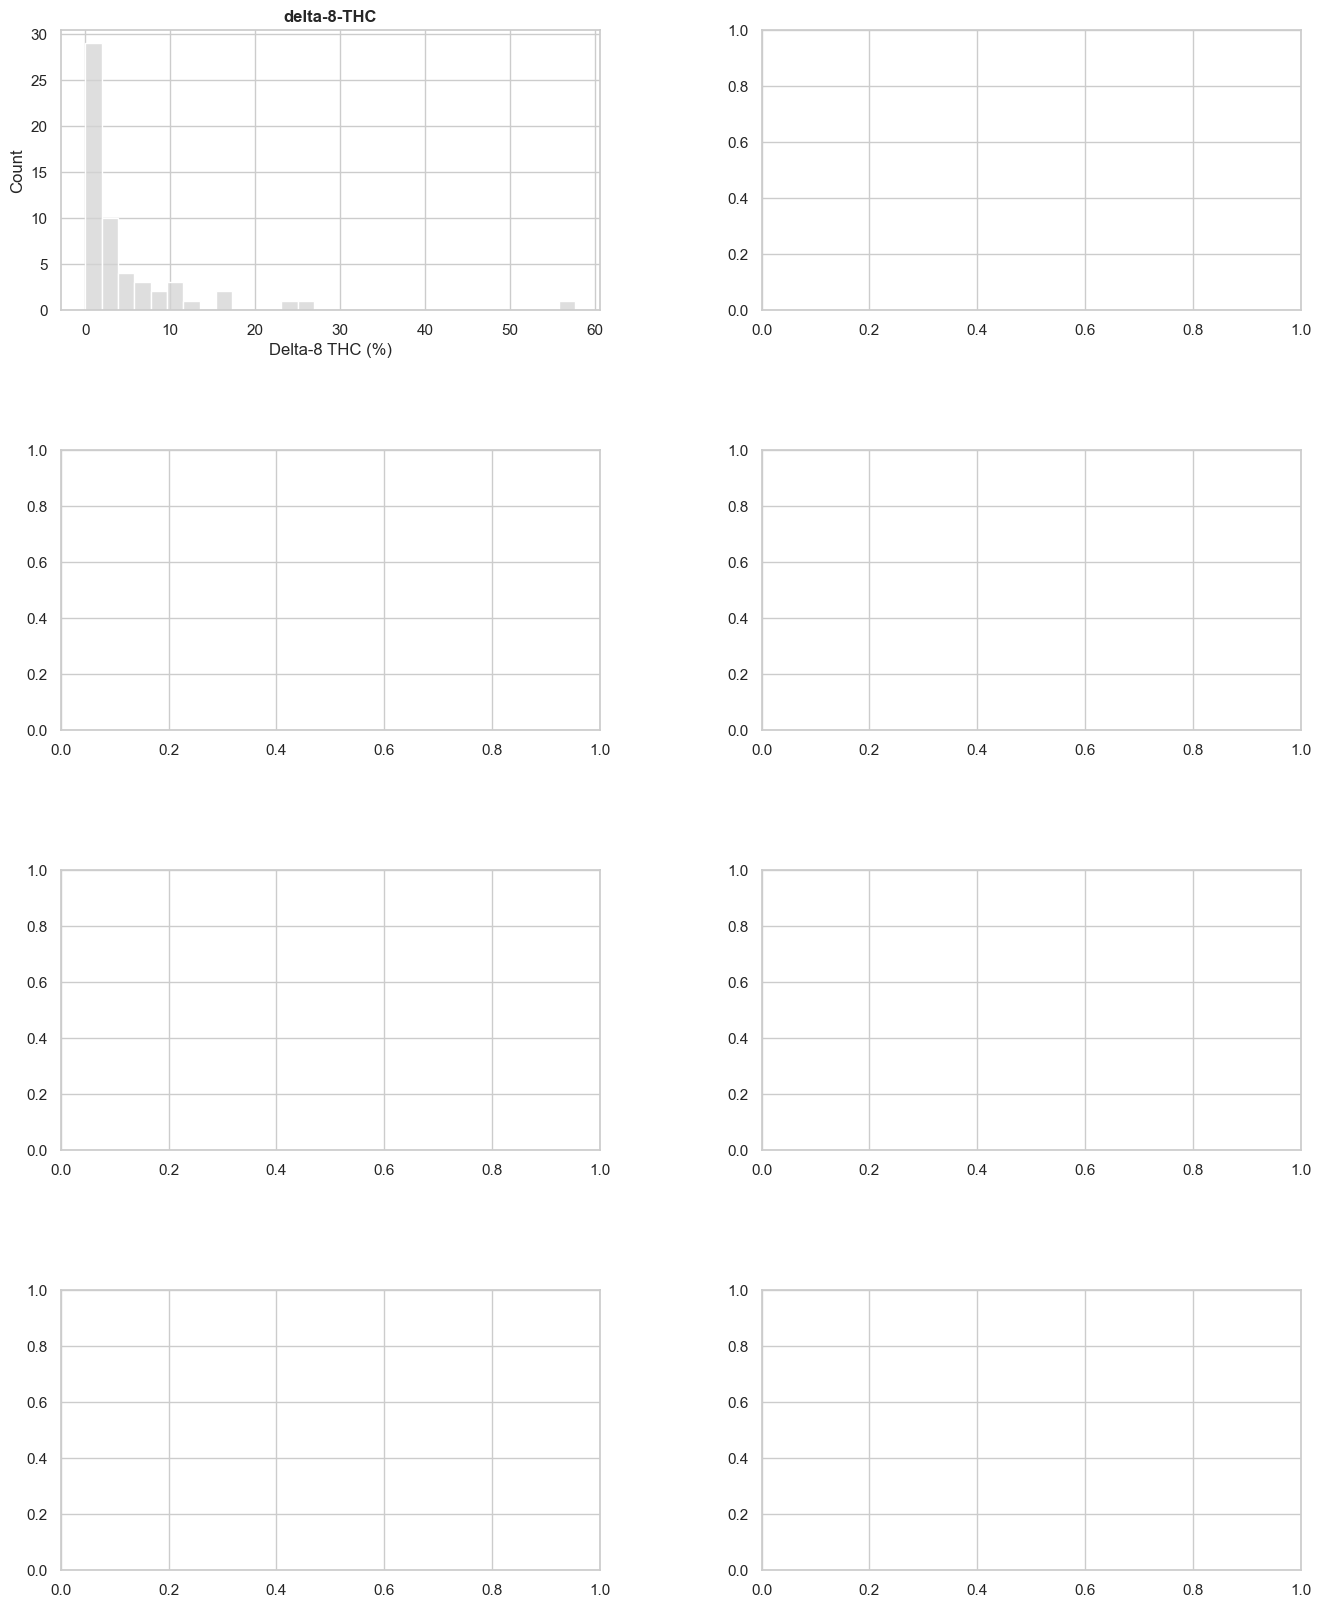

In [9]:
# --- COMPREHENSIVE OUTLIER VISUALIZATION ---
# Show test samples against reference distributions for ALL key markers
import matplotlib.pyplot as plt
import seaborn as sns

# Set up a 4x2 grid for 7 key markers (8 panels, 1 empty)
fig, axes = plt.subplots(4, 2, figsize=(16, 20))
plt.subplots_adjust(hspace=0.5, wspace=0.3)

# Define ALL key markers from our discovery phase
# Format: (Column Name, Axis Label, Scale Type)
# Log scale for solvents that span multiple orders of magnitude
# Linear scale for cannabinoids and solvents with narrow ranges
markers = [
    ('delta-8-THC', 'Delta-8 THC (%)', 'linear'),
    ('delta-10-THC', 'Delta-10 THC (%)', 'linear'),
    ('CBDa', 'CBDa (%)', 'linear'),
    ('Methanol', 'Methanol (ppm)', 'log'),       # Spans 10-1000+ ppm
    ('Heptane', 'Heptane (ppm)', 'log'),         # Spans 0.05-100+ ppm
    ('Toluene', 'Toluene (ppm)', 'linear'),      # Only one detection at 0.77 ppm
    ('Ethyl Acetate', 'Ethyl Acetate (ppm)', 'log'),  # Spans 100-1000+ ppm
]

for i, (marker, xlabel, scale) in enumerate(markers):
    ax = axes[i//2, i%2]
    
    # 1. Plot Reference Distribution (Gray Histogram)
    if marker in ref_vapes.columns:
        data = ref_vapes[ref_vapes[marker] > 0][marker]
        if len(data) > 0:
            try:
                sns.histplot(data, bins=30, color='lightgray', ax=ax, log_scale=(scale=='log'))
            except:
                sns.histplot(data, bins=30, color='lightgray', ax=ax)
    
    ax.set_title(f'{marker}', fontsize=12, fontweight='bold')
    ax.set_xlabel(xlabel)
    
    # 2. Plot ALL Test Samples with detections (Red Lines) - no threshold filtering
    if marker in final_df.columns:
        # Convert to numeric and filter > 0
        col_numeric = pd.to_numeric(final_df[marker], errors='coerce').fillna(0)
        hits = final_df[col_numeric > 0].copy()
        hits[marker] = col_numeric[col_numeric > 0]
        
        # Collect labels to position them without overlap
        labels = []
        for idx, row in hits.iterrows():
            val = row[marker]
            name = str(row['Product'])  # Ensure it's a string
            # Shorten long names
            short_name = name[:20] + '...' if len(name) > 20 else name
            labels.append((val, short_name))
            ax.axvline(val, color='red', linestyle='--', linewidth=2, alpha=0.8)
        
        # Add labels at top of plot, staggered to avoid overlap
        ylim = ax.get_ylim()
        for j, (val, name) in enumerate(labels):
            y_pos = ylim[1] * (0.95 - j * 0.12)  # Stagger vertically
            ax.annotate(f'{name}\n({val:.2f})', 
                       xy=(val, ylim[1]*0.5), 
                       xytext=(val, y_pos),
                       fontsize=8, color='red', fontweight='bold',
                       ha='center', va='top',
                       arrowprops=dict(arrowstyle='-', color='red', alpha=0.3))

# Hide the empty 8th panel
axes[3, 1].axis('off')

plt.suptitle("Test Samples (Red) vs. Reference Baseline (Gray)", fontsize=14, y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

print(f"\nShowing {len(markers)} key markers identified in discovery phase")
print("Red lines = test samples with detections")

---

## Multivariate comparison

*Moving beyond individual markers, we use dimensionality reduction (PCA) to see how test samples compare to the reference population in multi-dimensional chemical space.*

### Multivariate analysis: Test samples vs reference distribution

The previous visualizations looked at individual markers. Now we use multivariate analysis to see how test samples compare to the entire reference population in chemical space.

Critical methodological point: We fit PCA on the reference data (defining what "normal" looks like), then project test samples into that space. This tells us which test samples fall outside the normal reference distribution.

**We run THREE analyses to explore different perspectives:**

Analysis A: Focused Cannabinoid Markers (D8, D10, CBDa)
- Features: D8-THC, D10-THC, CBDa concentrations only
- These are the specific markers identified in discovery phase
- Most methodologically sound - both datasets have comparable sensitivity

Note on inter-laboratory variance: PCA on concentration values is more sensitive to inter-lab differences than analysis based on binary detection. Different laboratories may report concentrations that vary by 20-30% for the same sample. For the strongest conclusions, focus on whether D8-THC and D10-THC are detected at all (binary), rather than their exact PC1/PC2 coordinates. The PCA visualizations are useful for identifying outliers and patterns, but binary detection remains the most robust finding.

Analysis B: Cannabinoids + ALL Tier 1 Solvents (≥100 ppm)
- Features: D8-THC, D10-THC, CBDa + ALL solvents with values ≥100 ppm
- Includes: Methanol, Ethanol, Acetone, Heptane, Toluene, Ethyl Acetate, Isopropyl Alcohol
- Reference filtered to samples with at least one Tier 1 solvent detection
- Fair comparison - both labs can detect at this level

Analysis C: Expanded Cannabinoid Profile (D8, D10, CBDa, CBD, CBN)
- Features: Five cannabinoids that may indicate conversion or degradation
- CBD: Precursor for D8/D10 conversion
- CBN: Degradation product (may indicate age or processing)
- Provides broader chemical profile view


In [10]:
# --- MULTIVARIATE ANALYSIS: TEST SAMPLES VS REFERENCE DISTRIBUTION ---
# Running THREE analyses to explore different perspectives

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

SOLVENT_LOQ = 100  # Reference data limit of quantification

# HELPER FUNCTION: Run PCA analysis
def run_pca_analysis(ref_df, test_df, features):
    """
    Run PCA on reference data and project test samples.
    Returns: ref_pca, test_pca, loadings, var_explained, ref_centroid, ref_std
    """
    # Prepare reference data
    ref_data = pd.DataFrame()
    for f in features:
        if f in ref_df.columns:
            ref_data[f] = pd.to_numeric(ref_df[f], errors='coerce').fillna(0)
        else:
            ref_data[f] = 0
    
    # Prepare test data
    test_data = pd.DataFrame()
    for f in features:
        if f in test_df.columns:
            test_data[f] = pd.to_numeric(test_df[f], errors='coerce').fillna(0)
        else:
            test_data[f] = 0
    
    # Fit on reference
    scaler = StandardScaler()
    ref_scaled = scaler.fit_transform(ref_data)
    
    pca = PCA(n_components=2)
    ref_pca = pca.fit_transform(ref_scaled)
    
    # Project test samples
    test_scaled = scaler.transform(test_data)
    test_pca = pca.transform(test_scaled)
    
    # Get loadings
    loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=features)
    var_explained = pca.explained_variance_ratio_ * 100
    
    # Calculate centroid and distances
    ref_centroid = ref_pca.mean(axis=0)
    ref_std = ref_pca.std(axis=0)
    
    return ref_pca, test_pca, loadings, var_explained, ref_centroid, ref_std

# ANALYSIS A: FOCUSED CANNABINOID MARKERS (D8, D10, CBDa)
print("="*80)
print("ANALYSIS A: FOCUSED CANNABINOID MARKERS")
print("="*80)
print("Features: D8-THC, D10-THC, CBDa (discovery phase markers)")
print("Most methodologically sound - both datasets have similar sensitivity.\n")

features_A = ['delta-8-THC', 'delta-10-THC', 'CBDa']

ref_pca_A, test_pca_A, loadings_A, var_A, centroid_A, std_A = run_pca_analysis(
    full_ref, final_df, features_A
)

# Calculate Z-scores for Analysis A
test_z_pc1_A = (test_pca_A[:, 0] - centroid_A[0]) / std_A[0]
test_z_pc2_A = (test_pca_A[:, 1] - centroid_A[1]) / std_A[1]
final_df['PC1_Z_A'] = test_z_pc1_A
final_df['PC2_Z_A'] = test_z_pc2_A
final_df['PCA_Dist_A'] = np.sqrt(((test_pca_A - centroid_A) ** 2).sum(axis=1))

print(f"Reference samples: {len(ref_pca_A)}")
print(f"Test samples: {len(test_pca_A)}")
print(f"\nPCA Explained Variance:")
print(f"  PC1: {var_A[0]:.1f}%  PC2: {var_A[1]:.1f}%  Total: {sum(var_A):.1f}%")
print(f"\nFeature Loadings:\n{loadings_A.round(2).to_string()}")

outliers_A = final_df[(abs(final_df['PC1_Z_A']) > 2) | (abs(final_df['PC2_Z_A']) > 2)]
print(f"\nOutliers (|Z| > 2): {len(outliers_A)} samples")

# ANALYSIS B: CANNABINOIDS + ALL TIER 1 SOLVENTS (≥100 ppm)
# FILTERED to only reference samples with at least one Tier 1 solvent detection
print("\n" + "="*80)
print("ANALYSIS B: CANNABINOIDS + ALL TIER 1 SOLVENTS (≥100 ppm)")
print("="*80)
print("Features: D8-THC, D10-THC, CBDa + ALL solvents ≥100 ppm")
print("Reference FILTERED to samples with at least one Tier 1 solvent.\n")

# Define ALL solvents to check for Tier 1
all_solvents = ['Methanol', 'Ethanol', 'Acetone', 'Heptane', 'Toluene', 
                'Ethyl Acetate', 'Isopropyl Alcohol', 'Hexane', 'Benzene']

# Create Tier 1 columns for all solvents in both dataframes
tier1_flags = []
for solv in all_solvents:
    flag_name = solv.replace(' ', '_') + '_T1'
    tier1_flags.append(flag_name)
    
    if solv in full_ref.columns:
        full_ref[flag_name] = (full_ref[solv] >= SOLVENT_LOQ).astype(int)
    else:
        full_ref[flag_name] = 0
    
    if solv in final_df.columns:
        final_df[flag_name] = (final_df[solv] >= SOLVENT_LOQ).astype(int)
    else:
        final_df[flag_name] = 0

# Only include solvents that have ANY Tier 1 detections in reference
active_tier1_flags = [f for f in tier1_flags if full_ref[f].sum() > 0]
print(f"Tier 1 Solvent Detections in Reference (≥{SOLVENT_LOQ} ppm):")
for f in tier1_flags:
    count = full_ref[f].sum()
    if count > 0:
        print(f"  {f}: {count} samples")

# FILTER reference data to only samples with at least one Tier 1 solvent
full_ref['Any_Tier1_Solvent'] = full_ref[tier1_flags].max(axis=1, numeric_only=True)
ref_with_solvents = full_ref[full_ref['Any_Tier1_Solvent'] == 1].copy()

print(f"\nReference samples with ANY Tier 1 solvent: {len(ref_with_solvents)} of {len(full_ref)}")

# Features for Analysis B: cannabinoids + active Tier 1 solvent flags
features_B = ['delta-8-THC', 'delta-10-THC', 'CBDa'] + active_tier1_flags
print(f"Features used: {features_B}")

ref_pca_B, test_pca_B, loadings_B, var_B, centroid_B, std_B = run_pca_analysis(
    ref_with_solvents, final_df, features_B
)

# Calculate Z-scores for Analysis B
test_z_pc1_B = (test_pca_B[:, 0] - centroid_B[0]) / std_B[0]
test_z_pc2_B = (test_pca_B[:, 1] - centroid_B[1]) / std_B[1]
final_df['PC1_Z_B'] = test_z_pc1_B
final_df['PC2_Z_B'] = test_z_pc2_B
final_df['PCA_Dist_B'] = np.sqrt(((test_pca_B - centroid_B) ** 2).sum(axis=1))

print(f"\nReference samples: {len(ref_pca_B)}")
print(f"Test samples: {len(test_pca_B)}")
print(f"\nPCA Explained Variance:")
print(f"  PC1: {var_B[0]:.1f}%  PC2: {var_B[1]:.1f}%  Total: {sum(var_B):.1f}%")
print(f"\nFeature Loadings:\n{loadings_B.round(2).to_string()}")

outliers_B = final_df[(abs(final_df['PC1_Z_B']) > 2) | (abs(final_df['PC2_Z_B']) > 2)]
print(f"\nOutliers (|Z| > 2): {len(outliers_B)} samples")

# ANALYSIS C: EXPANDED CANNABINOID PROFILE (D8, D10, CBDa, CBD, CBN)
print("\n" + "="*80)
print("ANALYSIS C: EXPANDED CANNABINOID PROFILE")
print("="*80)
print("Features: D8-THC, D10-THC, CBDa, CBD, CBN")
print("Broader profile including precursor (CBD) and degradation product (CBN).\n")

features_C = ['delta-8-THC', 'delta-10-THC', 'CBDa', 'CBD', 'CBN']

ref_pca_C, test_pca_C, loadings_C, var_C, centroid_C, std_C = run_pca_analysis(
    full_ref, final_df, features_C
)

# Calculate Z-scores for Analysis C
test_z_pc1_C = (test_pca_C[:, 0] - centroid_C[0]) / std_C[0]
test_z_pc2_C = (test_pca_C[:, 1] - centroid_C[1]) / std_C[1]
final_df['PC1_Z_C'] = test_z_pc1_C
final_df['PC2_Z_C'] = test_z_pc2_C
final_df['PCA_Dist_C'] = np.sqrt(((test_pca_C - centroid_C) ** 2).sum(axis=1))

print(f"Reference samples: {len(ref_pca_C)}")
print(f"Test samples: {len(test_pca_C)}")
print(f"\nPCA Explained Variance:")
print(f"  PC1: {var_C[0]:.1f}%  PC2: {var_C[1]:.1f}%  Total: {sum(var_C):.1f}%")
print(f"\nFeature Loadings:\n{loadings_C.round(2).to_string()}")

outliers_C = final_df[(abs(final_df['PC1_Z_C']) > 2) | (abs(final_df['PC2_Z_C']) > 2)]
print(f"\nOutliers (|Z| > 2): {len(outliers_C)} samples")

# VISUALIZATION: All three analyses
fig, axes = plt.subplots(3, 2, figsize=(16, 18))
flagged_mask = final_df['Any_Flag'].values

def plot_pca(ax, ref_pca, test_pca, centroid, var, loadings, title, n_ref):
    """Helper to plot PCA scatter"""
    ax.scatter(ref_pca[:, 0], ref_pca[:, 1], c='#17becf', s=4, alpha=0.35, label=f'Reference (n={n_ref})')
    ax.scatter(test_pca[~flagged_mask, 0], test_pca[~flagged_mask, 1], 
               c='#ff7f0e', s=50, edgecolors='#cc6600', linewidth=0.5, alpha=0.9, label='Test - Not Flagged')
    ax.scatter(test_pca[flagged_mask, 0], test_pca[flagged_mask, 1], 
               c='#d62728', s=70, edgecolors='black', linewidth=0.8, alpha=1.0, label='Test - Flagged')
    for i, (idx, row) in enumerate(final_df.iterrows()):
        if row.get('Any_Flag', False):
            product_name = str(row['Product'])
            short_name = product_name[:10] + '..' if len(product_name) > 10 else product_name
            ax.annotate(short_name, (test_pca[i, 0], test_pca[i, 1]), 
                        xytext=(5, 5), textcoords='offset points', fontsize=5, color='darkred')
    ax.scatter([centroid[0]], [centroid[1]], c='#9467bd', s=100, marker='X', 
               edgecolors='#5c3d7a', linewidths=1.5, alpha=0.7, label='Ref Centroid', zorder=10)
    ax.set_xlabel(f"PC1 ({var[0]:.0f}%): {', '.join(loadings['PC1'].abs().nlargest(2).index)}", fontsize=8)
    ax.set_ylabel(f"PC2 ({var[1]:.0f}%): {', '.join(loadings['PC2'].abs().nlargest(2).index)}", fontsize=8)
    ax.set_title(title, fontsize=10, fontweight='bold')
    ax.legend(loc='upper right', fontsize=6)
    ax.grid(True, alpha=0.3)

# --- Row 1: Analysis A ---
plot_pca(axes[0, 0], ref_pca_A, test_pca_A, centroid_A, var_A, loadings_A,
         f'Analysis A: FOCUSED MARKERS (D8, D10, CBDa)\nn={len(ref_pca_A)} reference', len(ref_pca_A))
sns.heatmap(loadings_A, annot=True, cmap='RdBu_r', center=0, fmt='.2f', ax=axes[0, 1], 
            cbar_kws={'label': 'Loading'}, annot_kws={'size': 9})
axes[0, 1].set_title('Analysis A: Feature Loadings', fontsize=10, fontweight='bold')

# --- Row 2: Analysis B ---
plot_pca(axes[1, 0], ref_pca_B, test_pca_B, centroid_B, var_B, loadings_B,
         f'Analysis B: CANNABINOIDS + ALL TIER 1 SOLVENTS\nn={len(ref_pca_B)} ref (with solvents)', len(ref_pca_B))
sns.heatmap(loadings_B, annot=True, cmap='RdBu_r', center=0, fmt='.2f', ax=axes[1, 1], 
            cbar_kws={'label': 'Loading'}, annot_kws={'size': 7})
axes[1, 1].set_title('Analysis B: Feature Loadings', fontsize=10, fontweight='bold')
axes[1, 1].tick_params(axis='y', labelsize=7)

# --- Row 3: Analysis C ---
plot_pca(axes[2, 0], ref_pca_C, test_pca_C, centroid_C, var_C, loadings_C,
         f'Analysis C: EXPANDED CANNABINOIDS (D8, D10, CBDa, CBD, CBN)\nn={len(ref_pca_C)} reference', len(ref_pca_C))
sns.heatmap(loadings_C, annot=True, cmap='RdBu_r', center=0, fmt='.2f', ax=axes[2, 1], 
            cbar_kws={'label': 'Loading'}, annot_kws={'size': 9})
axes[2, 1].set_title('Analysis C: Feature Loadings', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# SUMMARY: COMPARISON OF ALL THREE ANALYSES
print("\n" + "="*80)
print("SUMMARY: COMPARING ALL THREE ANALYSES")
print("="*80)

print("\n--- Analysis A: Focused Cannabinoid Markers ---")
print("Top 5 outliers by distance from reference centroid:")
summary_A = final_df[['Product', 'PC1_Z_A', 'PC2_Z_A', 'PCA_Dist_A', 'Any_Flag']].copy()
summary_A['Outside'] = (abs(summary_A['PC1_Z_A']) > 2) | (abs(summary_A['PC2_Z_A']) > 2)
summary_A = summary_A.sort_values('PCA_Dist_A', ascending=False)
print(summary_A.head(5).to_string(index=False, float_format=lambda x: "{:.2f}".format(x) if isinstance(x, float) else x))

print("\n--- Analysis B: Cannabinoids + ALL Tier 1 Solvents ---")
print("Top 5 outliers by distance from reference centroid:")
summary_B = final_df[['Product', 'PC1_Z_B', 'PC2_Z_B', 'PCA_Dist_B', 'Any_Flag']].copy()
summary_B['Outside'] = (abs(summary_B['PC1_Z_B']) > 2) | (abs(summary_B['PC2_Z_B']) > 2)
summary_B = summary_B.sort_values('PCA_Dist_B', ascending=False)
print(summary_B.head(5).to_string(index=False, float_format=lambda x: "{:.2f}".format(x) if isinstance(x, float) else x))

print("\n--- Analysis C: Expanded Cannabinoid Profile ---")
print("Top 5 outliers by distance from reference centroid:")
summary_C = final_df[['Product', 'PC1_Z_C', 'PC2_Z_C', 'PCA_Dist_C', 'Any_Flag']].copy()
summary_C['Outside'] = (abs(summary_C['PC1_Z_C']) > 2) | (abs(summary_C['PC2_Z_C']) > 2)
summary_C = summary_C.sort_values('PCA_Dist_C', ascending=False)
print(summary_C.head(5).to_string(index=False, float_format=lambda x: "{:.2f}".format(x) if isinstance(x, float) else x))

print("\n" + "="*80)
print("KEY INSIGHTS")
print("="*80)
print(f"""
ANALYSIS A (Focused Markers: D8, D10, CBDa):
- Uses ALL {len(ref_pca_A)} reference samples
- Focused on the specific markers identified in discovery phase
- Most reliable for identifying hemp-derived conversion products
- Outliers: {len(outliers_A)} samples with |Z| > 2

ANALYSIS B (Cannabinoids + ALL Tier 1 Solvents):
- Reference FILTERED to {len(ref_pca_B)} samples with Tier 1 solvents (≥100 ppm)
- Includes: Methanol, Ethanol, Acetone, Ethyl Acetate, Isopropyl Alcohol, etc.
- Fair comparison - both labs can detect at this level
- Shows how test samples compare to other solvent-containing products
- Outliers: {len(outliers_B)} samples with |Z| > 2

ANALYSIS C (Expanded Cannabinoids: D8, D10, CBDa, CBD, CBN):
- Uses ALL {len(ref_pca_C)} reference samples
- Adds CBD (precursor) and CBN (degradation product)
- Provides broader chemical profile context
- May show different patterns based on processing/age
- Outliers: {len(outliers_C)} samples with |Z| > 2

RECOMMENDATION:
- Analysis A: Primary result for hemp-derived conversion detection
- Analysis B: Supplementary for solvent context (when applicable)
- Analysis C: Broader profile for general chemical characterization
""")

ANALYSIS A: FOCUSED CANNABINOID MARKERS
Features: D8-THC, D10-THC, CBDa (discovery phase markers)
Most methodologically sound - both datasets have similar sensitivity.



NameError: name 'final_df' is not defined

### Direct chemical relationship scatter plots

While PCA is powerful for multivariate analysis, the axes (PC1, PC2) are abstract combinations of features. These direct scatter plots show actual chemical concentrations against each other for easier interpretation.

Row 1: Cannabinoid-Cannabinoid Pairs (Methodologically Sound)
- D8-THC vs D10-THC — Conversion byproducts (strongest signal)
- D8-THC vs CBD — Conversion product vs precursor
- D8-THC vs CBDa — Conversion product vs precursor

Row 2: Cannabinoid-Solvent Pairs (With LOQ Caveats)
- D8-THC vs Methanol — Conversion product + process solvent
- CBDa vs Methanol — Precursor + process solvent
- Methanol vs Ethyl Acetate — Solvent-solvent relationship

Important: The dashed orange line at 100 ppm marks the reference LOQ threshold.
- Points ABOVE the line = Tier 1 (can be compared to reference data)
- Points BELOW the line = Tier 2 (detected but below reference sensitivity)

**Color coding:**
- Red points: Flagged samples (have suspicious markers)
- Blue points: Normal samples


Generating Direct Chemical Relationship Scatter Plots...


NameError: name 'final_df' is not defined

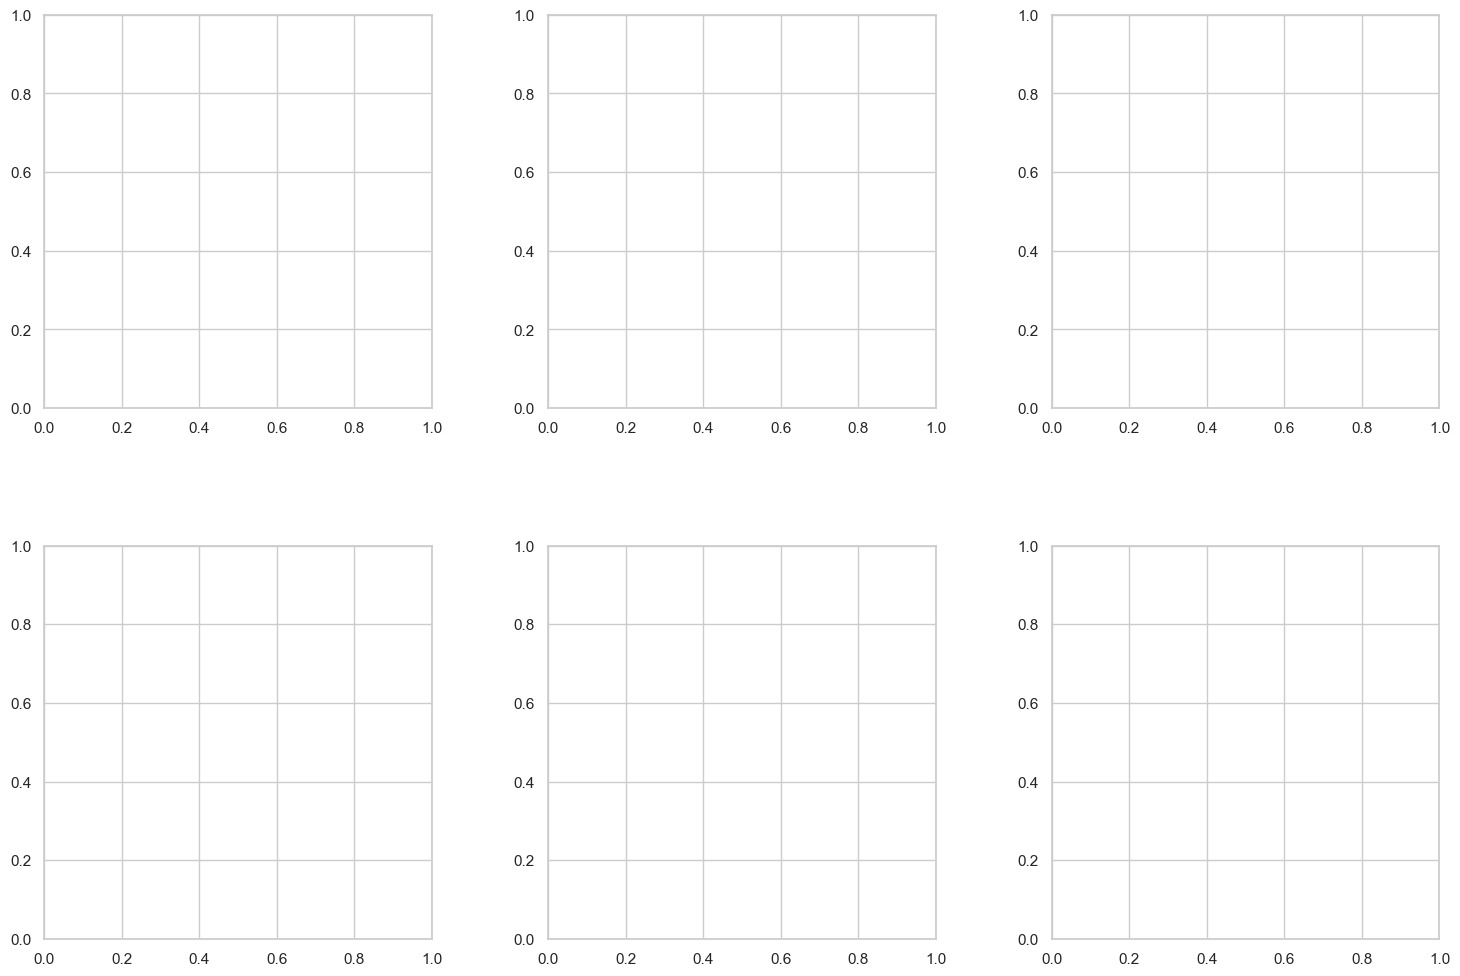

In [11]:
# --- DIRECT 2D SCATTER PLOTS ---
# Plot actual chemical concentrations against each other for interpretability
# Row 1: Cannabinoid-Cannabinoid (methodologically sound)
# Row 2: Cannabinoid-Solvent (with LOQ threshold lines)

print("Generating Direct Chemical Relationship Scatter Plots...")

SOLVENT_LOQ = 100  # Reference data limit of quantification

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
plt.subplots_adjust(hspace=0.35, wspace=0.3)

# Define pairs to plot
# Row 1: Cannabinoid-Cannabinoid (no LOQ issues)
# Row 2: Cannabinoid-Solvent or Solvent-Solvent (need LOQ lines)
pairs = [
    # Row 1: Cannabinoid pairs (methodologically sound)
    ('delta-8-THC', 'delta-10-THC', 'D8-THC vs D10-THC\n(Conversion Byproducts)', False, False),
    ('delta-8-THC', 'CBD', 'D8-THC vs CBD\n(Product vs Precursor)', False, False),
    ('delta-8-THC', 'CBDa', 'D8-THC vs CBDa\n(Product vs Precursor)', False, False),
    # Row 2: Solvent pairs (need LOQ lines)
    ('delta-8-THC', 'Methanol', 'D8-THC vs Methanol\n(Product + Process Solvent)', False, True),
    ('CBDa', 'Methanol', 'CBDa vs Methanol\n(Precursor + Process Solvent)', False, True),
    ('Methanol', 'Ethyl Acetate', 'Methanol vs Ethyl Acetate\n(Solvent-Solvent)', True, True),
]

for i, (x_col, y_col, title, x_is_solvent, y_is_solvent) in enumerate(pairs):
    ax = axes[i//3, i%3]
    
    # Get numeric values
    x_vals = pd.to_numeric(final_df[x_col], errors='coerce').fillna(0) if x_col in final_df.columns else pd.Series([0]*len(final_df))
    y_vals = pd.to_numeric(final_df[y_col], errors='coerce').fillna(0) if y_col in final_df.columns else pd.Series([0]*len(final_df))
    
    # Color by flag status
    colors = ['#d62728' if flag else '#ff7f0e' for flag in final_df['Any_Flag']]
    edge_colors = ['black' if flag else '#cc6600' for flag in final_df['Any_Flag']]
    
    ax.scatter(x_vals, y_vals, c=colors, s=60, alpha=0.9, edgecolors=edge_colors, linewidths=0.7, zorder=5)
    
    # Add LOQ threshold lines for solvent axes
    if y_is_solvent:
        ax.axhline(y=SOLVENT_LOQ, color='orange', linestyle='--', linewidth=2, alpha=0.8, 
                   label=f'LOQ ({SOLVENT_LOQ} ppm)', zorder=3)
        # Shade the below-LOQ region
        xlim = ax.get_xlim()
        ax.fill_between([xlim[0]-1000, xlim[1]+1000], 0, SOLVENT_LOQ, 
                        color='orange', alpha=0.1, zorder=1)
        ax.set_xlim(xlim)
    
    if x_is_solvent:
        ax.axvline(x=SOLVENT_LOQ, color='orange', linestyle='--', linewidth=2, alpha=0.8, zorder=3)
        # Shade the below-LOQ region
        ylim = ax.get_ylim()
        ax.fill_between([0, SOLVENT_LOQ], ylim[0]-1000, ylim[1]+1000, 
                        color='orange', alpha=0.1, zorder=1)
        ax.set_ylim(ylim)
    
    # Label flagged samples (only if they have non-zero values)
    for idx, row in final_df.iterrows():
        if row.get('Any_Flag', False):
            x = x_vals[final_df.index.get_loc(idx)]
            y = y_vals[final_df.index.get_loc(idx)]
            if x > 0 or y > 0:  # Only label if visible
                product_name = str(row['Product'])
                short_name = product_name[:12] + '..' if len(product_name) > 12 else product_name
                ax.annotate(short_name, (x, y), xytext=(5, 5), textcoords='offset points', 
                           fontsize=7, color='darkred', zorder=10)
    
    # Format axis labels
    x_label = x_col.replace('delta-', 'D').replace('-THC', '-THC (%)')
    y_label = y_col.replace('delta-', 'D').replace('-THC', '-THC (%)')
    if x_is_solvent:
        x_label = f'{x_col} (ppm)'
    if y_is_solvent:
        y_label = f'{y_col} (ppm)'
    
    ax.set_xlabel(x_label, fontsize=10)
    ax.set_ylabel(y_label, fontsize=10)
    ax.set_title(title, fontsize=10, fontweight='bold')
    ax.grid(True, alpha=0.3, zorder=0)

# Add legend
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
legend_elements = [
    Patch(facecolor='#d62728', edgecolor='black', label='Flagged Sample'),
    Patch(facecolor='#ff7f0e', edgecolor='#cc6600', label='Normal Sample'),
    Line2D([0], [0], color='orange', linestyle='--', linewidth=2, label=f'Solvent LOQ ({SOLVENT_LOQ} ppm)'),
    Patch(facecolor='orange', alpha=0.3, label='Below LOQ (Tier 2)')
]
fig.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.99, 0.99), fontsize=9)

plt.suptitle('Direct Chemical Relationships\nRow 1: Cannabinoids (reliable) | Row 2: Solvents (with LOQ threshold)', 
             fontsize=13, y=1.02)
plt.tight_layout()
plt.show()



---

## Conclusion

### Critical context: Label claims vs. chemical evidence

All test products in this analysis claim to be derived entirely from cannabis, not hemp. The key question is:

> Do these products contain markers that are inconsistent with their label claims?

D8-THC and D10-THC are binary markers — they are either present or absent. Unlike magnitude comparisons (which can be affected by inter-laboratory variance), presence/absence findings are robust and legally defensible. Finding these cannabinoids in products claiming to be "100% cannabis" constitutes direct evidence of misrepresentation or adulteration.

---

### Analysis methodology

**Methodology:**

1. Co-occurrence Analysis: Identified which chemicals appear together more often than expected
2. Concentration Correlation: Measured whether chemical concentrations are linearly related
3. Marker Application: Applied discovered patterns to flag suspicious test samples
4. Tiered Flagging: Accounted for LOQ differences between reference and test data
5. Multiple Comparison Correction: Applied Benjamini-Hochberg FDR correction to all p-values
6. Multivariate Analysis: Three PCA analyses to visualize test samples in reference chemical space

Data sources: Reference data from Bona Fide Labs (~24,000 samples); test data from Kaycha Labs (28 samples).

**Note on Discarded Analysis:**
We initially explored cannabinoid-solvent concentration correlations (e.g., D8-THC vs Methanol concentrations). This analysis was discarded because:
- Very few samples had both cannabinoid and solvent detected (N=1-6 per pair)
- The reference LOQ (~100 ppm) means most solvent detections are not captured
- The co-occurrence heatmaps already captured these relationships more reliably via co-occurrence ratios

---

### Key findings

1. Discovery Phase: Chemical Signatures of Hemp-Derived Conversion

| Pattern | Finding | Interpretation |
|---------|---------|----------------|
| D8-THC + D10-THC | 28x co-occurrence, r = 0.94 | Co-produced via isomerization - strongest marker |
| D8-THC + CBD/CBDa | 6-8x co-occurrence, r > 0.9 | CBD is the precursor for conversion |
| D9-THC + THCa | ~1x co-occurrence, r = -0.07 | Natural biosynthesis - no correlation (baseline) |

The contrast between conversion products (r > 0.9) and natural cannabis (r ~ 0) is the fingerprint that distinguishes hemp-derived from legitimate cannabis.

Forensic Validation: These findings align with peer-reviewed forensic chemistry research. Kiselak et al. (2020) documented that acid-catalyzed CBD isomerization consistently produces D8-THC, D9-THC and an unidentified compound at 5.6 min retention time (suspected to be D10-THC) across all tested reaction pathways (sulfuric acid, hydrochloric acid and acetic acid). The D8+D10 co-occurrence pattern we observe (28x co-occurrence, r = 0.94) is not merely statistically unusual — it is the expected chemical signature of CBD isomerization as documented in forensic literature.

Commercial Product Analysis: Meehan-Atrash & Rahman (2021) analyzed 27 commercial Δ8-THC vaporizer products and found that ALL contained reaction byproducts from CBD isomerization, including Δ4(8)-iso-THC (2-13% in all samples), olivetol and heavy metals. None had accurate labeling. This confirms that commercial Δ8-THC products are manufactured via CBD isomerization rather than natural extraction and that the chemical markers we identify (D8-THC, D10-THC, process solvents) are reliable indicators of this conversion process.

2. Multivariate Analysis Results

| Analysis | Features | Reference | Key Finding |
|----------|----------|-----------|-------------|
| A: Focused Markers | D8, D10, CBDa | 23,782 samples | Rockin Extracts is the only statistical outlier (|Z| > 2) |
| B: + Tier 1 Solvents | + Methanol, Ethanol, etc. ≥100 ppm | 373 samples (with solvents) | Rockin Extracts remains outlier; Cali Blaze within normal for solvent-containing products |
| C: Expanded Cannabinoids | + CBD, CBN | 23,782 samples | Rockin Extracts outlier; CBD/CBDa drive PC1 (hemp signature) |

3. Flagged Test Samples

*Products with findings consistent with misrepresentation (binary detection):*

These products contain D8-THC or D10-THC — cannabinoids that are not naturally abundant in cannabis and are produced primarily via hemp CBD isomerization. Their presence in products claiming to be "100% cannabis" is consistent with mislabeling:

- Rockin Extracts Cartridge: D10-THC at 3.35% — Consistent outlier across all PCA analyses
- Nerd Bar Disposable: D8-THC at 1.31%
- Dutch Botanicals Cartridge: D8-THC at 1.09%

*Solvent detections:*
- Cali Blaze Pre-Roll: Methanol at 428 ppm — Well above reference detection limit (4x LOQ)
- Flyin' Hawaiian Cartridge: Toluene at 0.77 ppm — Toluene is specifically associated with industrial-scale CBD→THC conversion

*Solvent Detections (Tiered by LOQ):*

| Tier | Criteria | Samples | Interpretation |
|------|----------|---------|----------------|
| TIER 1 | ≥100 ppm | Cali Blaze (428 ppm Methanol) | Can compare to reference data |
| TIER 2 | >0 but <100 ppm | Multiple samples | Below reference LOQ |

4. Total Flagged: 12 of 28 samples (43%)

---

### Critical methodological limitation: Solvent detection limits

**The reference data and test data use different analytical sensitivities:**
- Reference data LOQ: ~100 ppm (no values between 0-100 ppm exist)
- Test data sensitivity: <1 ppm

**Impact on Analysis:**
- Cannabinoid analysis is fully valid (similar sensitivity)
- Cannabinoid-cannabinoid co-occurrence patterns are fully valid
- Solvent analysis requires tiered interpretation:
  - Tier 1 (≥100 ppm): Can compare to reference
  - Tier 2 (<100 ppm): Detected but cannot determine if unusual

---

### Confidence summary

| Confidence | Criteria | Samples | Interpretation |
|------------|----------|---------|----------------|
| HIGH CONFIDENCE | D8-THC or D10-THC detected | Rockin Extracts, Nerd Bar, Dutch Botanicals | Binary marker — inconsistent with "cannabis-only" claim |
| POTENTIALLY SIGNIFICANT | Methanol ≥100 ppm | Cali Blaze Pre-Roll (428 ppm) | Above reference LOQ; methanol also used in extraction |
| POTENTIALLY SIGNIFICANT | Toluene detected | Flyin' Hawaiian (0.77 ppm) | Associated with industrial CBD→THC conversion |

---

### Recommendations

**High-confidence findings (recommend further investigation):**
1. Rockin Extracts, Nerd Bar, Dutch Botanicals — These products contain D8-THC or D10-THC, which should not exist in legitimate cannabis products. The presence of these cannabinoids is inconsistent with their "100% cannabis" label claims.

**Potentially significant findings:**
2. Cali Blaze Pre-Roll — Methanol at 428 ppm (4x above reference LOQ). Methanol is used in both conversion chemistry and some extraction processes.
3. Flyin' Hawaiian Cartridge — Toluene at 0.77 ppm. Toluene is specifically associated with scaled industrial sonication-assisted CBD→THC conversion (Ramirez et al., 2024).

**Methodological Notes:**
4. The D8+D10 co-occurrence pattern (28x co-occurrence, r = 0.94) is the most reliable indicator of hemp-derived conversion chemistry.
5. All statistical tests have been corrected for multiple comparisons using Benjamini-Hochberg FDR.

---

### Limitations

**Data limitations:**
- Reference categories (Vapes/Concentrates, Flower/Buds) contain mixed THC-dominant and CBD-dominant products, introducing baseline heterogeneity
- Solvent sensitivity gap: Reference LOQ (~100 ppm) is higher than test lab sensitivity (<1 ppm), making Tier 2 solvent findings inconclusive
- Small test sample size (n=28)

**Analytical limitations:**
- Quantitative concentration comparisons are subject to 20-30% inter-laboratory variance; binary detection (present/absent) is more robust
- No regulatory threshold mapping — this analysis identifies statistical anomalies, not regulatory violations

---

### References

1. Kiselak TD, Koerber R, Verbeck GF. (2020). Synthetic route sourcing of illicit at home cannabidiol (CBD) isomerization to psychoactive cannabinoids using ion mobility-coupled-LC–MS/MS. *Forensic Science International*, 308:110173. https://doi.org/10.1016/j.forsciint.2020.110173

2. Gaoni Y, Mechoulam R. (1966). Hashish—VII: The isomerization of cannabidiol to tetrahydrocannabinols. *Tetrahedron*, 22(4):1481-1488.

3. Adams R, Cain C, McPhee W, Wearn R. (1941). Structure of cannabidiol. XII. Isomerization to Tetrahydrocannabinols. *Journal of the American Chemical Society*, 63(8):2209-2213.

4. Ramirez GA, Cruces W, Pittiglio M, Tesfatsion TT, Docampo-Palacios ML, et al. (2024). Ultrasonic or Microwave Modified Continuous Flow Chemistry for the Synthesis of Tetrahydrocannabinol: Observing Effects of Various Solvents and Acids. *ACS Omega*, 9(3):9794. https://doi.org/10.1021/acsomega.3c09794

5. Marzullo P, Foschi F, Coppini DA, et al. (2020). Cannabidiol as the Substrate in Acid-Catalyzed Intramolecular Cyclization. *Journal of Natural Products*, 83(10):2894-2901.

6. Meehan-Atrash J, Rahman I. (2021). Novel Δ8-Tetrahydrocannabinol Vaporizers Contain Unlabeled Adulterants, Unintended Byproducts of Chemical Synthesis and Heavy Metals. *Chemical Research in Toxicology*. https://doi.org/10.1021/acs.chemrestox.1c00388

7. Ieritano C, Thomas P, Hopkins WS. (2023). Argentination: A Silver Bullet for Cannabinoid Separation by Differential Mobility Spectrometry. *Analytical Chemistry*. https://doi.org/10.1021/acs.analchem.3c01241